In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc  # garbage collection

In [2]:
#matplotlib 한글깨짐 지원
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)    

In [3]:
demo = pd.read_csv('Demo.csv', encoding = 'cp949')
purchase_list = pd.read_csv('구매내역정보.csv', encoding = 'cp949')

df = pd.merge(demo, purchase_list, on = 'ID')
df.구매일자 = df.구매일자.astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문
df['num'] = df.index # 거래데이터의 index를 'num'에 생성

# 성별을 한글로 바꿈 (편의성을 위함)
df['성별'] = df.성별.apply(lambda x : '남' if x==1 else '여')

# 구매요일 삽입
df['구매요일'] = df.구매일자.dt.weekday.apply(lambda x : ('월','화','수','목','금','토','일')[x])

# 필요없는 데이터 삭제 & 가비지 컬렉션 통한 메모리 관리
del demo, purchase_list
gc.collect()

df.head()

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,num,구매요일
0,478207946,남,84,서울 성동구,가전제품,컴퓨터주변기기,서울 동대문구,2014-12-19,13,1,59000,0,0,금
1,478207946,남,84,서울 성동구,가전제품,TV/AV,서울 동대문구,2014-10-31,14,1,106000,0,1,금
2,478207946,남,84,서울 성동구,가전제품,주방가전,서울 중구,2014-08-15,15,1,37000,0,2,금
3,478207946,남,84,서울 성동구,의류잡화,여성용의류-이너웨어,서울 동대문구,2014-03-22,17,1,118000,0,3,토
4,479806984,남,84,서울 서초구,생활잡화,화장품,서울 중구,2014-07-04,12,1,22000,0,4,금


# Data Cleansing

### [1] 구매금액 & 구매건수 비율이 잘못된 데이터 제거

In [4]:
# 구매금액이나 구매건수 컬럼이 잘못되어 있는 비율

print(df.query('구매금액 == 0 or 구매수량 == 0').shape[0])

# case-1
print(df.query('구매금액 != 0 and 구매수량 == 0').shape[0])
# case-2
print(df.query('구매금액 == 0 and 구매수량 != 0').shape[0])
# case-3
print(df.query('구매금액 == 0 and 구매수량 == 0').shape[0])

200
0
200
0


In [5]:
# 해결책
# case=3 : 해당 레코드 삭제
df = df.query('구매금액 != 0')
df

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,num,구매요일
0,478207946,남,84,서울 성동구,가전제품,컴퓨터주변기기,서울 동대문구,2014-12-19,13,1,59000,0,0,금
1,478207946,남,84,서울 성동구,가전제품,TV/AV,서울 동대문구,2014-10-31,14,1,106000,0,1,금
2,478207946,남,84,서울 성동구,가전제품,주방가전,서울 중구,2014-08-15,15,1,37000,0,2,금
3,478207946,남,84,서울 성동구,의류잡화,여성용의류-이너웨어,서울 동대문구,2014-03-22,17,1,118000,0,3,토
4,479806984,남,84,서울 서초구,생활잡화,화장품,서울 중구,2014-07-04,12,1,22000,0,4,금
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101687,955481370,여,58,경기 의왕시,의류잡화,남성용의류-정장류,경기 안양시,2014-12-25,19,1,60000,0,101687,목
101688,955481370,여,58,경기 의왕시,의류잡화,패션잡화,경기 안양시,2014-12-25,19,3,93000,0,101688,목
101689,955481370,여,58,경기 의왕시,가전제품,생활가전,경기 안양시,2014-12-12,20,1,1057000,0,101689,금
101690,821581510,여,64,경기 안양시,식품,가공식품,경기 광명시,2014-12-21,12,1,5000,0,101690,일


### [2] 개당 거래가격이 이상한 값 제거

In [6]:
# 개당 거래가격 열 생성
df['개당가격'] = (df['구매금액'] / df['구매수량'])
df['개당가격'] = df.개당가격.astype(int)

In [7]:
# 상품중분류명 별 개당 가격 오름차순 정렬 (1~20)
df.sort_values(by='개당가격').groupby('상품중분류명')['개당가격'].unique().reset_index().iloc[:20]

,상품중분류명,개당가격
0,PC/노트북/프린터/카메라,"[3000, 9000, 11000, 13000, 16000, 17000, 18000..."
1,TV/AV,"[4000, 6000, 13000, 22000, 23000, 24000, 25000..."
2,가공식품,"[10, 71, 83, 85, 86, 87, 88, 89, 90, 97, 333, ..."
3,가구,"[1000, 3000, 4000, 4500, 5000, 6000, 6333, 650..."
4,건강식품,"[833, 863, 875, 878, 880, 885, 888, 900, 904, ..."
5,골프용품/의류,"[800, 885, 886, 888, 894, 898, 1000, 2000, 400..."
6,구두,"[87, 88, 90, 125, 889, 1000, 2000, 4000, 5000,..."
7,남성용의류-정장류,"[3000, 4000, 4400, 4500, 5000, 7000, 8000, 900..."
8,남성용의류-캐주얼,"[2000, 3533, 4000, 5000, 6000, 6166, 6500, 700..."
9,농산물,"[333, 500, 666, 750, 833, 857, 900, 1000, 1250..."


In [8]:
# 상품중분류명 별 개당 가격 오름차순 정렬 (21~31)
df.sort_values(by='개당가격').groupby('상품중분류명')['개당가격'].unique().reset_index().iloc[20:]

,상품중분류명,개당가격
20,여성용의류-캐주얼,"[9000, 14000, 17000, 18000, 22000, 26000, 2650..."
21,음료,"[250, 325, 333, 350, 400, 458, 500, 650, 666, ..."
22,주방가전,"[89, 90, 200, 500, 857, 875, 880, 884, 885, 88..."
23,주방용품,"[87, 88, 89, 93, 125, 166, 885, 886, 887, 888,..."
24,주얼리,"[9000, 11000, 40000, 45000, 66000, 67000, 7800..."
25,축산물,"[875, 1000, 2000, 3000, 4000, 4500, 5000, 5500..."
26,침구류,"[866, 875, 883, 884, 887, 888, 889, 890, 892, ..."
27,컴퓨터주변기기,"[1000, 1500, 2000, 3000, 3500, 4000, 4500, 500..."
28,패션잡화,"[884, 888, 1000, 2000, 2500, 2600, 2750, 3000,..."
29,화장품,"[1000, 2000, 2666, 3000, 4000, 4500, 5000, 550..."


#### 개당 거래가격이 상품중분류명별 의심되는 상품을 따로 분류하여 개당가격 분포를 파악

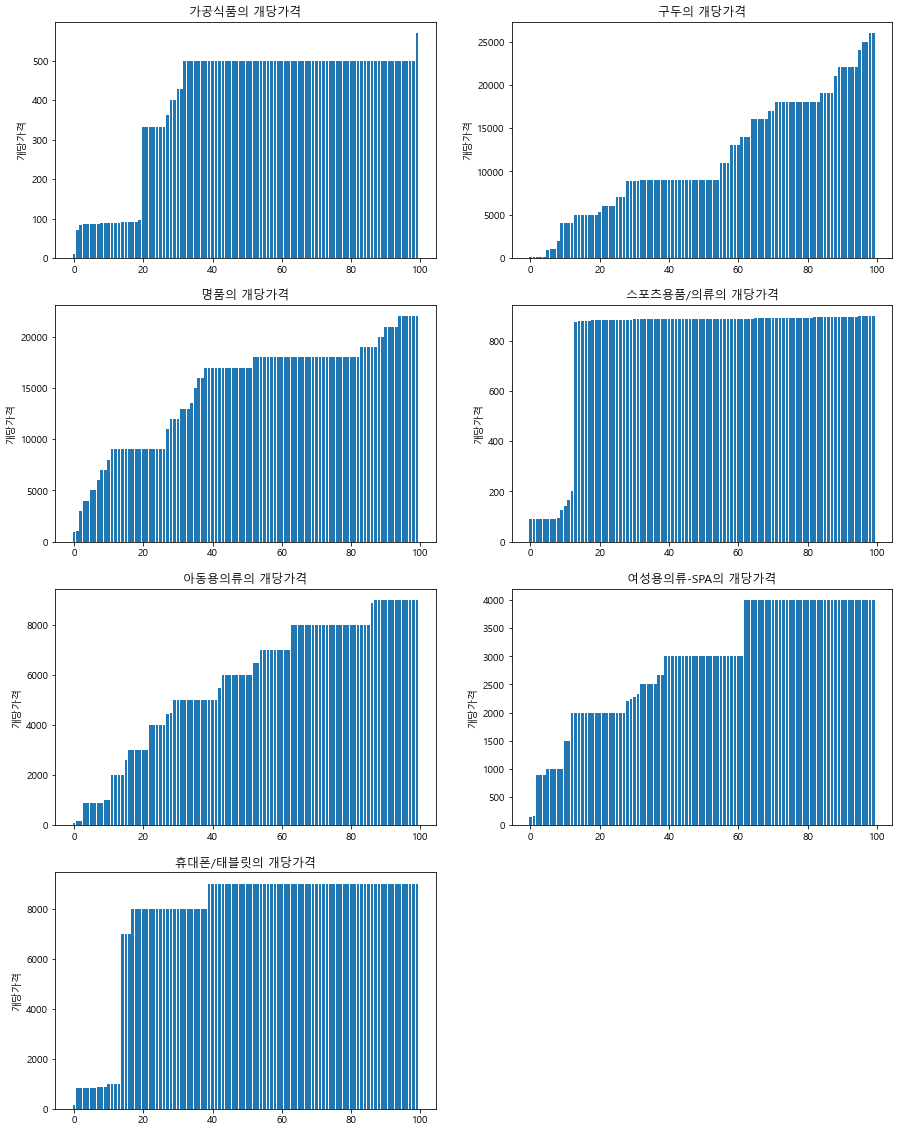

In [9]:
# 가공식품
a = df.query('상품중분류명 == "가공식품"').sort_values(by='개당가격').iloc[:100]['개당가격'].reset_index().reset_index()
x = a['level_0']
y = a['개당가격']

plt.figure(figsize=(15,20))
plt.subplot(4,2,1)
plt.title('가공식품의 개당가격')
plt.ylabel('개당가격')
plt.bar(x,y)


# 구두
a_1 = df.query('상품중분류명 == "구두"').sort_values(by='개당가격').iloc[:100]['개당가격'].reset_index().reset_index()
x_1 = a_1['level_0']
y_1 = a_1['개당가격']

plt.subplot(4,2,2)
plt.title('구두의 개당가격')
plt.ylabel('개당가격')
plt.bar(x_1,y_1)


# 명품
a_2 = df.query('상품중분류명 == "명품"').sort_values(by='개당가격').iloc[:100]['개당가격'].reset_index().reset_index()
x_2 = a_2['level_0']
y_2 = a_2['개당가격']


plt.subplot(4,2,3)
plt.title('명품의 개당가격')
plt.ylabel('개당가격')
plt.bar(x_2,y_2)


# 스포츠용품/의류
a_3 = df.query('상품중분류명 == "스포츠용품/의류"').sort_values(by='개당가격').iloc[:100]['개당가격'].reset_index().reset_index()
x_3 = a_3['level_0']
y_3 = a_3['개당가격']


plt.subplot(4,2,4)
plt.title('스포츠용품/의류의 개당가격')
plt.ylabel('개당가격')
plt.bar(x_3,y_3)


# 아동용의류
a_4 = df.query('상품중분류명 == "아동용의류"').sort_values(by='개당가격').iloc[:100]['개당가격'].reset_index().reset_index()
x_4 = a_4['level_0']
y_4 = a_4['개당가격']

plt.subplot(4,2,5)
plt.title('아동용의류의 개당가격')
plt.ylabel('개당가격')
plt.bar(x_4,y_4)


# 여성용의류-SPA
a_5 = df.query('상품중분류명 == "여성용의류-SPA"').sort_values(by='개당가격').iloc[:100]['개당가격'].reset_index().reset_index()
x_5 = a_5['level_0']
y_5 = a_5['개당가격']

plt.subplot(4,2,6)
plt.title('여성용의류-SPA의 개당가격')
plt.ylabel('개당가격')
plt.bar(x_5,y_5)


# 휴대폰/태블릿
a_8 = df.query('상품중분류명 == "휴대폰/태블릿"').sort_values(by='개당가격').iloc[:100]['개당가격'].reset_index().reset_index()
x_8 = a_8['level_0']
y_8 = a_8['개당가격']

plt.subplot(4,2,7)
plt.title('휴대폰/태블릿의 개당가격')
plt.ylabel('개당가격')
plt.bar(x_8,y_8)
plt.show()

#### 주로 계단식 구조를 이루는 특징을 알 수 있음
#### 넓은 계단층 분포가 형성된 가격은 실제 품목 별 인터넷 검색 후 데이터 전처리에 참고하였음

In [10]:
# 각 상품중분류 별 개당 가격이 이상한 값 제거 (총 27개의 데이터)
clean_1=list(df.query('상품중분류명=="가공식품"&개당가격<=20').num)
clean_2=list(df.query('상품중분류명=="구두"&(개당가격<=125)').num)
clean_3=list(df.query('상품중분류명=="명품"&(개당가격<=1000)').num)
clean_4=list(df.query('상품중분류명=="스포츠용품/의류"&(개당가격<=200)').num)
clean_5=list(df.query('상품중분류명=="아동용의류"&(개당가격<=167)').num)
clean_6=list(df.query('상품중분류명=="여성용의류-SPA"&(개당가격<=167)').num)
clean_7=list(df.query('상품중분류명=="휴대폰/태블릿"&(개당가격<=143)').num)
cleansing=clean_1+clean_2+clean_3+clean_4+clean_5+clean_6+clean_7
df=df.query('num != @cleansing')
df

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,num,구매요일,개당가격
0,478207946,남,84,서울 성동구,가전제품,컴퓨터주변기기,서울 동대문구,2014-12-19,13,1,59000,0,0,금,59000
1,478207946,남,84,서울 성동구,가전제품,TV/AV,서울 동대문구,2014-10-31,14,1,106000,0,1,금,106000
2,478207946,남,84,서울 성동구,가전제품,주방가전,서울 중구,2014-08-15,15,1,37000,0,2,금,37000
3,478207946,남,84,서울 성동구,의류잡화,여성용의류-이너웨어,서울 동대문구,2014-03-22,17,1,118000,0,3,토,118000
4,479806984,남,84,서울 서초구,생활잡화,화장품,서울 중구,2014-07-04,12,1,22000,0,4,금,22000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101687,955481370,여,58,경기 의왕시,의류잡화,남성용의류-정장류,경기 안양시,2014-12-25,19,1,60000,0,101687,목,60000
101688,955481370,여,58,경기 의왕시,의류잡화,패션잡화,경기 안양시,2014-12-25,19,3,93000,0,101688,목,31000
101689,955481370,여,58,경기 의왕시,가전제품,생활가전,경기 안양시,2014-12-12,20,1,1057000,0,101689,금,1057000
101690,821581510,여,64,경기 안양시,식품,가공식품,경기 광명시,2014-12-21,12,1,5000,0,101690,일,5000


### [3] 특이값 제거

해당 데이터 분석의 주 목적은 '실버세대의 라이프스타일을 이해할 수 있는 특징을 분석 및 추정하고 이와 관련된 마케팅 전략을 제시' 하는 것임.

따라서 본 팀은 품목 별 거래금액이 비상싱적으로 큰 경우 (상품별 전체 금액 비율 고려) 해당 데이터를  '기업' or '법인카드 내역'으로 판단하여 제거하기로 판단

In [11]:
before = pd.pivot_table(df,index = 'ID',columns = '상품중분류명',values = '구매금액',aggfunc = 'sum',fill_value=0).reset_index()
before

상품중분류명,ID,PC/노트북/프린터/카메라,TV/AV,가공식품,가구,건강식품,골프용품/의류,구두,남성용의류-정장류,남성용의류-캐주얼,...,음료,주방가전,주방용품,주얼리,축산물,침구류,컴퓨터주변기기,패션잡화,화장품,휴대폰/태블릿
0,741463,0,0,0,0,196000,0,0,0,44000,...,0,0,0,0,0,0,0,0,0,0
1,909249,0,0,46000,0,0,0,111000,0,108000,...,0,28000,0,0,0,116000,0,9000,0,0
2,1065068,0,0,22000,0,0,0,0,0,0,...,0,201000,0,0,0,66000,0,0,679000,0
3,1310410,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,196000,0
4,1387032,0,0,75000,0,0,0,27000,0,0,...,0,0,11000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,998623524,887000,0,12000,17000,47000,0,142000,300000,38000,...,0,117000,0,0,0,0,75000,0,77000,0
3537,999024423,0,0,0,0,0,0,0,0,0,...,0,6000,0,0,0,0,0,0,0,0
3538,999184958,0,0,9000,0,0,0,0,0,0,...,0,574000,832000,0,18000,168000,0,216000,0,0
3539,999375162,0,0,86000,2336000,0,0,0,0,497000,...,12000,58000,0,0,0,326000,0,40000,0,0


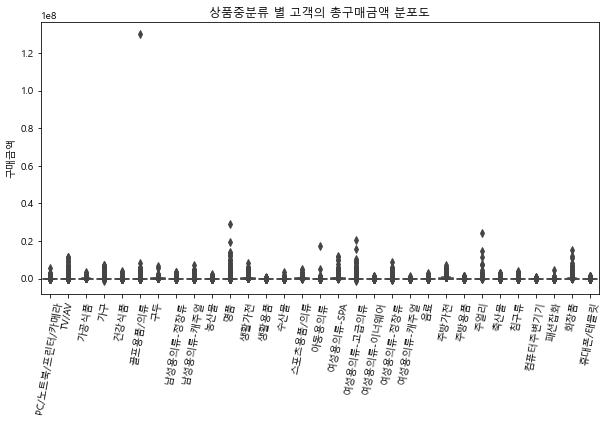

In [12]:
# boxplot 함수
def outlier_check(data):
    plt.figure(figsize = (10,5))
    sns.boxplot(data=data)
    plt.xticks(rotation=80, ticks=np.arange(0,31), labels = [col for col in before.columns[1:]])
    plt.title('상품중분류 별 고객의 총구매금액 분포도')
    plt.ylabel('구매금액')
    plt.show()

outlier_check([before[col] for col in before.columns[1:]])

'골프용품/의류' 품목에서 특이값을 가짐

In [13]:
# 골프용품/의류 ID별 구매금액
golf = df.query('상품중분류명 == "골프용품/의류"').groupby('ID')['구매금액'].sum().reset_index().sort_values(by='구매금액', ascending = False).head(20); golf

,ID,구매금액
307,700882892,130010000
289,658972837,8227000
161,346413459,6064000
377,815878702,5629000
470,997677778,5140000
37,67292818,4676000
73,153345164,4041000
246,552627258,3725000
399,861579076,3240000
238,539032107,3164000


In [14]:
# ID = 700882892인 고객의 구매내역
df.query('ID==700882892').groupby('상품중분류명')['구매금액'].sum().reset_index().sort_values(by='구매금액', ascending = False)

,상품중분류명,구매금액
2,골프용품/의류,130010000
5,생활가전,4028000
0,TV/AV,735000
9,여성용의류-정장류,538000
1,가공식품,247000
4,농산물,241000
6,수산물,144000
13,패션잡화,141000
12,주방용품,75000
11,주방가전,70000


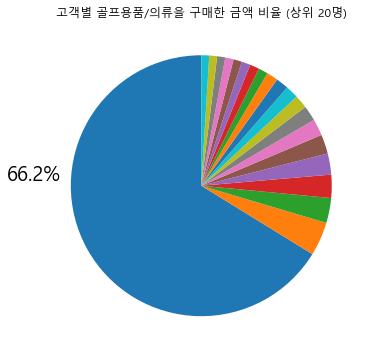

In [15]:
# 골프용품/의류 품목에서의 전체 구매금액 중 고객별 차지하는 비율
golf = df.query('상품중분류명 == "골프용품/의류"').groupby('ID')['구매금액'].sum().reset_index().sort_values(by='구매금액', ascending = False).query('구매금액>=0').head(20)
labels = golf['ID'].astype(str); size=golf['구매금액']

plt.figure(figsize=(8,6))
plt.pie(size,
       startangle = 90)
plt.title('고객별 골프용품/의류을 구매한 금액 비율 (상위 20명)')
plt.ylabel('66.2%',rotation=0,fontsize=20)
plt.show()

1억3천만원을 구매한 'ID:700882892'를 제외한 나머지 고객의 구매 분포가 크지않아 더욱 직관적인 판단을 위해 상위20명의 데이터만 불러옴.

ID:700882892 가 상위 20명 중 50%가 넘는 비율을 차지하는 것으로 보아 전체 비율에도 큰 부분을 차지함을 알 수 있음.
이에 따라 해당 고객은 스크린골프장을 운영하는 법인, 골프용품/의류를 대량으로 구매한 도매업자, 골프용품/의류 전문 기업으로 판단하여 해당 데이터를 제거하기로 판단.

In [16]:
# ID:700882892의 골프 거래내역 삭제
clean_golf = list(df.query('ID == 700882892 & 상품중분류명 == "골프용품/의류"').num)
df = df.query('num != @clean_golf')
df

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,num,구매요일,개당가격
0,478207946,남,84,서울 성동구,가전제품,컴퓨터주변기기,서울 동대문구,2014-12-19,13,1,59000,0,0,금,59000
1,478207946,남,84,서울 성동구,가전제품,TV/AV,서울 동대문구,2014-10-31,14,1,106000,0,1,금,106000
2,478207946,남,84,서울 성동구,가전제품,주방가전,서울 중구,2014-08-15,15,1,37000,0,2,금,37000
3,478207946,남,84,서울 성동구,의류잡화,여성용의류-이너웨어,서울 동대문구,2014-03-22,17,1,118000,0,3,토,118000
4,479806984,남,84,서울 서초구,생활잡화,화장품,서울 중구,2014-07-04,12,1,22000,0,4,금,22000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101687,955481370,여,58,경기 의왕시,의류잡화,남성용의류-정장류,경기 안양시,2014-12-25,19,1,60000,0,101687,목,60000
101688,955481370,여,58,경기 의왕시,의류잡화,패션잡화,경기 안양시,2014-12-25,19,3,93000,0,101688,목,31000
101689,955481370,여,58,경기 의왕시,가전제품,생활가전,경기 안양시,2014-12-12,20,1,1057000,0,101689,금,1057000
101690,821581510,여,64,경기 안양시,식품,가공식품,경기 광명시,2014-12-21,12,1,5000,0,101690,일,5000


In [17]:
after = pd.pivot_table(df,index = 'ID', columns = '상품중분류명', values = '구매금액', aggfunc = 'sum',  fill_value= 0).reset_index()
after

상품중분류명,ID,PC/노트북/프린터/카메라,TV/AV,가공식품,가구,건강식품,골프용품/의류,구두,남성용의류-정장류,남성용의류-캐주얼,...,음료,주방가전,주방용품,주얼리,축산물,침구류,컴퓨터주변기기,패션잡화,화장품,휴대폰/태블릿
0,741463,0,0,0,0,196000,0,0,0,44000,...,0,0,0,0,0,0,0,0,0,0
1,909249,0,0,46000,0,0,0,111000,0,108000,...,0,28000,0,0,0,116000,0,9000,0,0
2,1065068,0,0,22000,0,0,0,0,0,0,...,0,201000,0,0,0,66000,0,0,679000,0
3,1310410,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,196000,0
4,1387032,0,0,75000,0,0,0,27000,0,0,...,0,0,11000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,998623524,887000,0,12000,17000,47000,0,142000,300000,38000,...,0,117000,0,0,0,0,75000,0,77000,0
3537,999024423,0,0,0,0,0,0,0,0,0,...,0,6000,0,0,0,0,0,0,0,0
3538,999184958,0,0,9000,0,0,0,0,0,0,...,0,574000,832000,0,18000,168000,0,216000,0,0
3539,999375162,0,0,86000,2336000,0,0,0,0,497000,...,12000,58000,0,0,0,326000,0,40000,0,0


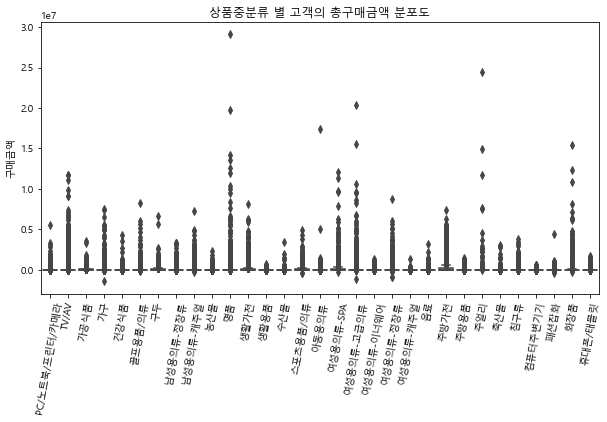

In [18]:
outlier_check([after[col] for col in after.columns[1:]])

명품, 아동용의류, 여성용의류-고급의류, 주얼리에서 특이값 존재가 의심

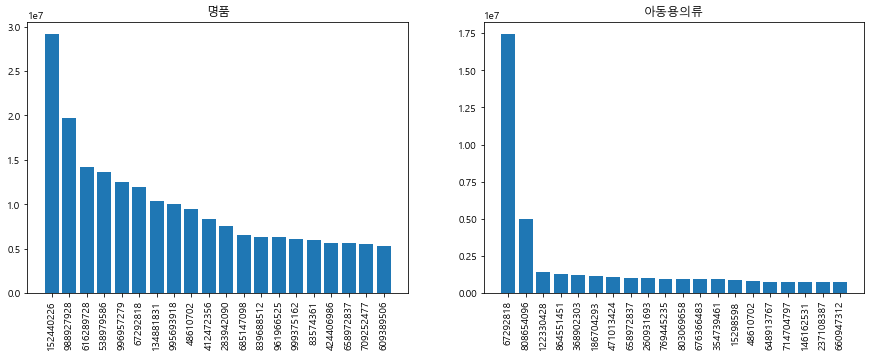

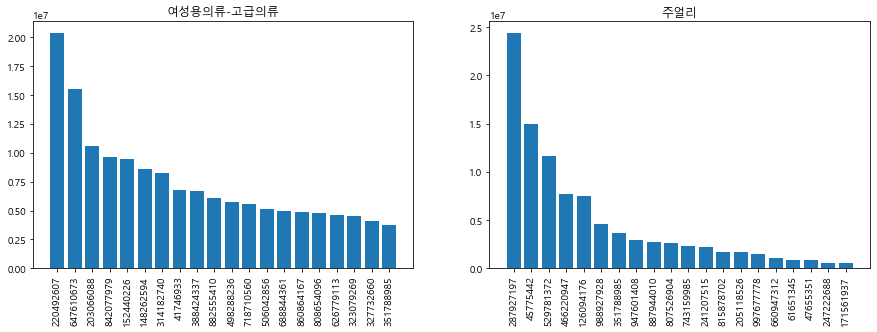

In [19]:
#명품
luxury_1=df.query('상품중분류명 == "명품"').groupby('ID')['구매금액'].sum().sort_values(ascending = False).reset_index().head(20)
x_1=luxury_1['ID'].astype(str); y_1=luxury_1['구매금액']

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.xticks(rotation = 90)
plt.title('명품')
plt.bar(x_1,y_1)

# 아동용의류
luxury_2=df.query('상품중분류명 == "아동용의류"').groupby('ID')['구매금액'].sum().sort_values(ascending = False).reset_index().head(20)
x_2=luxury_2['ID'].astype(str); y_2=luxury_2['구매금액']

plt.subplot(1,2,2)
plt.xticks(rotation = 90)
plt.title('아동용의류')
plt.bar(x_2,y_2)


# 여성용의류-고급의류
luxury_3=df.query('상품중분류명 == "여성용의류-고급의류"').groupby('ID')['구매금액'].sum().sort_values(ascending = False).reset_index().head(20)
x_3=luxury_3['ID'].astype(str); y_3=luxury_3['구매금액']

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.xticks(rotation = 90)
plt.title('여성용의류-고급의류')
plt.bar(x_3,y_3)

# 주얼리
luxury_4=df.query('상품중분류명 == "주얼리"').groupby('ID')['구매금액'].sum().sort_values(ascending = False).reset_index().head(20)
x_4=luxury_4['ID'].astype(str); y_4=luxury_4['구매금액']

plt.subplot(2,2,2)
plt.xticks(rotation = 90)
plt.title('주얼리')
plt.bar(x_4,y_4)
plt.show()

# '아동용의류'에서 대량구매 의심

In [20]:
# 아동용의류 부문 구매액 1위 ID
df.query('상품중분류명 == "아동용의류"').groupby('ID')['구매금액'].sum().sort_values(ascending = False).index[0]

67292818

In [21]:
df.query('ID == 67292818 & 상품중분류명 == "아동용의류" & 구매수량 >0').sort_values(by='구매수량', ascending = False).iloc[:20]

,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,num,구매요일,개당가격
4981,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-10-01,13,30,30000,0,4981,수,1000
4980,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-10-01,13,8,114000,0,4980,수,14250
4987,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-10-16,13,3,35000,0,4987,목,11666
4979,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-10-01,13,3,12000,0,4979,수,4000
5072,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-11-08,14,3,59000,0,5072,토,19666
5203,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-12-26,16,2,8000,0,5203,금,4000
4904,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-07-10,12,1,121000,0,4904,목,121000
5075,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-11-13,14,1,187000,0,5075,목,187000
5134,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-07-05,15,1,391000,0,5134,토,391000
5133,67292818,여,71,서울 중구,의류잡화,아동용의류,서울 중구,2014-07-05,15,1,97000,0,5133,토,97000


아동용의류 부문 구매 1위 고객은 대량구매자, 악의적인 구매자가 아니므로 유효한 데이터라 판단

### [4] 기타

In [22]:
df.isna().sum()

ID        0
성별        0
연령        0
거주지역      0
상품대분류명    0
상품중분류명    0
구매지역      0
구매일자      0
구매시간      0
구매수량      0
구매금액      0
취소여부      0
num       0
구매요일      0
개당가격      0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101396 entries, 0 to 101691
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ID      101396 non-null  int64         
 1   성별      101396 non-null  object        
 2   연령      101396 non-null  int64         
 3   거주지역    101396 non-null  object        
 4   상품대분류명  101396 non-null  object        
 5   상품중분류명  101396 non-null  object        
 6   구매지역    101396 non-null  object        
 7   구매일자    101396 non-null  datetime64[ns]
 8   구매시간    101396 non-null  int64         
 9   구매수량    101396 non-null  int64         
 10  구매금액    101396 non-null  int64         
 11  취소여부    101396 non-null  int64         
 12  num     101396 non-null  int64         
 13  구매요일    101396 non-null  object        
 14  개당가격    101396 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(7), object(6)
memory usage: 12.0+ MB


In [24]:
# 데이터 요약
print('=======  분석 데이터 요약  =======')
print('▶ 고객수:', df.ID.nunique())
print(f'▶ 상품수: 대분류({df.상품대분류명.nunique()}), 중분류({df.상품중분류명.nunique()})')
print(f'▶ 기간: {df.구매일자.min()} ~ {df.구매일자.max()} ({(df.구매일자.max()-df.구매일자.min()).days+1}일)')

=======  분석 데이터 요약  =======
▶ 고객수: 3541
▶ 상품수: 대분류(7), 중분류(31)
▶ 기간: 2014-01-01 00:00:00 ~ 2014-12-31 00:00:00 (365일)


# Segment

## 1.Feature Generation

새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.

In [25]:
features = pd.DataFrame({'ID' : df.ID.unique()})

**[1]** 총구매액, 구매건수 

In [26]:
f = df.groupby('ID')['구매금액'].agg([
    ('총구매액',np.sum)
]).reset_index()
f_1 = df.query('구매수량 > 0').groupby('ID')['구매수량'].count().reset_index().rename(columns = {'구매수량' : '구매건수'})
f = pd.merge(f, f_1,on='ID', how='left')

In [27]:
features = features.merge(f, how='left'); features

,ID,총구매액,구매건수
0,478207946,320000,4
1,479806984,318000,5
2,94790213,216000,7
3,656026338,29000,3
4,433076833,1583000,172
...,...,...,...
3536,154314532,846000,3
3537,416998709,41000,3
3538,168692065,10000,2
3539,955481370,1219000,4


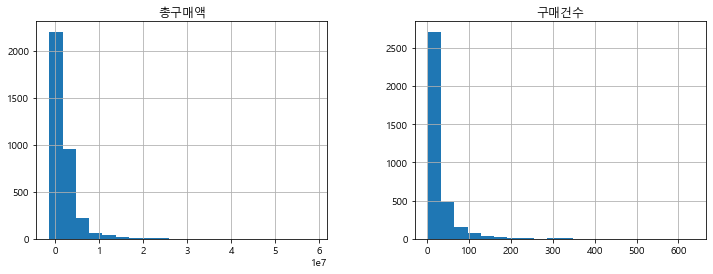

In [28]:
f.iloc[:,1:].hist(bins=20, figsize=(12,4))
plt.show()

**[2]** 내점일수, 구매주기, 주말방문율

In [29]:
f = df.groupby('ID')['구매일자'].agg([
    ('내점일수',lambda x : x.nunique()),
    ('구매주기', lambda x : int(((x.max()-x.min()).days)/x.nunique())),
    ('주말방문율', lambda x : (x.dt.weekday>4).mean().round(2))
]).reset_index()

In [30]:
now = df.구매일자.max()+pd.DateOffset(days=1)
df.groupby('ID')['구매일자'].agg(lambda x, y : (y-x).min().days, now).reset_index()

,ID,구매일자
0,741463,275
1,909249,7
2,1065068,3
3,1310410,81
4,1387032,31
...,...,...
3536,998623524,3
3537,999024423,42
3538,999184958,77
3539,999375162,11


In [31]:
df.groupby('ID')['num'].count()

ID
741463        7
909249       29
1065068      11
1310410       2
1387032       6
             ..
998623524    19
999024423     3
999184958    26
999375162    50
999494396     4
Name: num, Length: 3541, dtype: int64

In [32]:
features = features.merge(f, how = 'left'); features

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율
0,478207946,320000,4,4,68,0.25
1,479806984,318000,5,3,64,0.20
2,94790213,216000,7,6,51,0.00
3,656026338,29000,3,3,80,0.00
4,433076833,1583000,172,79,4,0.16
...,...,...,...,...,...,...
3536,154314532,846000,3,2,10,0.00
3537,416998709,41000,3,1,0,1.00
3538,168692065,10000,2,1,0,0.00
3539,955481370,1219000,4,2,6,0.00


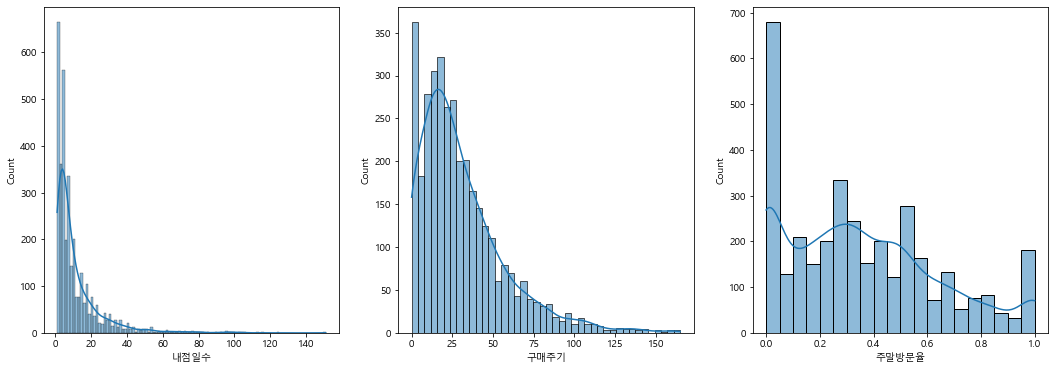

In [33]:
fig, ax = plt.subplots(1,3 ,figsize=(18,6))

sns.histplot(f, x='내점일수', kde=True, ax = ax[0])
sns.histplot(f, x='구매주기', kde=True, ax = ax[1])
sns.histplot(f, x='주말방문율', kde=True, ax = ax[2])
plt.show()

**[3]** 방문 당 평균 구매액, 구매건수

In [34]:
vst_cnt = df.groupby('ID')['구매일자'].agg(lambda x : x.nunique()) # 취소한것도 방문횟수로 취급
per_amount = (df.groupby('ID')['구매금액'].sum()/vst_cnt).round(0).reset_index().astype(int).rename(columns = {0:'방문당구매액'})
per_count = (df.query('구매수량>0').groupby('ID')['구매수량'].count()/vst_cnt).round(1).reset_index().rename(columns = {0:'방문당구매건수'})
f = pd.merge(per_amount, per_count, on='ID')

In [35]:
features = features.merge(f, how='left'); features

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수
0,478207946,320000,4,4,68,0.25,80000,1.0
1,479806984,318000,5,3,64,0.20,106000,1.7
2,94790213,216000,7,6,51,0.00,36000,1.2
3,656026338,29000,3,3,80,0.00,9667,1.0
4,433076833,1583000,172,79,4,0.16,20038,2.2
...,...,...,...,...,...,...,...,...
3536,154314532,846000,3,2,10,0.00,423000,1.5
3537,416998709,41000,3,1,0,1.00,41000,3.0
3538,168692065,10000,2,1,0,0.00,10000,2.0
3539,955481370,1219000,4,2,6,0.00,609500,2.0


**[4]** 주 구매시간

In [36]:
f = df.groupby('ID')['구매시간'].agg([
    ('주구매시간', lambda x : int(x.value_counts().index[0]))
]).reset_index()

In [37]:
features = features.merge(f, how='left'); features

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간
0,478207946,320000,4,4,68,0.25,80000,1.0,17
1,479806984,318000,5,3,64,0.20,106000,1.7,12
2,94790213,216000,7,6,51,0.00,36000,1.2,17
3,656026338,29000,3,3,80,0.00,9667,1.0,16
4,433076833,1583000,172,79,4,0.16,20038,2.2,14
...,...,...,...,...,...,...,...,...,...
3536,154314532,846000,3,2,10,0.00,423000,1.5,16
3537,416998709,41000,3,1,0,1.00,41000,3.0,19
3538,168692065,10000,2,1,0,0.00,10000,2.0,19
3539,955481370,1219000,4,2,6,0.00,609500,2.0,19


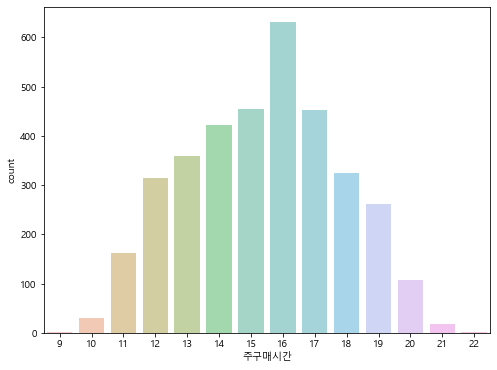

In [38]:
# 시간대별 구매빈도 파악
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x = '주구매시간', data=f, alpha=0.5)
plt.show()

**[5]** 최고가상품값

In [39]:
f = df.groupby('ID')['개당가격'].agg({
    ('최고가상품값', np.max)
}).reset_index()
features = features.merge(f, how='left')

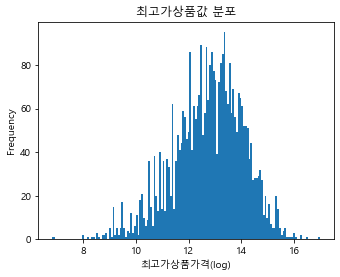

In [40]:
plt.figure(figsize=(18,4))

plt.subplot(1,3,1)
features.최고가상품값.apply(lambda x : np.log1p(x)).plot.hist(bins = 150)
plt.title('최고가상품값 분포')
plt.xlabel('최고가상품가격(log)')
plt.show()

**[6]** 구매추세

In [41]:
# 마지막날짜부터 365일전까지 (14일씩 26번) 매주 구매건수를 계산하여 리스트에 넣음
week_to = df.구매일자.max()
week_trans = []
for i in range(26):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < 구매일자 <= @week_to')
                      .groupby('ID')['구매일자']
                      .agg([(f'w{26-i}', 'count')])
                      .reset_index())
    week_to = week_from

# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'ID': df.ID.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)
f.head()

,ID,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w17,w18,w19,w20,w21,w22,w23,w24,w25,w26
0,478207946,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,479806984,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,94790213,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,656026338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,433076833,5.0,4.0,1.0,4.0,3.0,3.0,5.0,1.0,8.0,...,7.0,1.0,2.0,7.0,0.0,4.0,11.0,1.0,5.0,4.0


In [42]:
f['구매추세'] = f.apply(lambda x: np.polyfit(range(26), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,최고가상품값,구매추세
0,478207946,320000,4,4,68,0.25,80000,1.0,17,118000,0.01
1,479806984,318000,5,3,64,0.20,106000,1.7,12,120000,-0.02
2,94790213,216000,7,6,51,0.00,36000,1.2,17,35000,-0.00
3,656026338,29000,3,3,80,0.00,9667,1.0,16,13000,-0.00
4,433076833,1583000,172,79,4,0.16,20038,2.2,14,86000,0.04
...,...,...,...,...,...,...,...,...,...,...,...
3536,154314532,846000,3,2,10,0.00,423000,1.5,16,684000,0.02
3537,416998709,41000,3,1,0,1.00,41000,3.0,19,21000,0.02
3538,168692065,10000,2,1,0,0.00,10000,2.0,19,9000,0.02
3539,955481370,1219000,4,2,6,0.00,609500,2.0,19,1057000,0.03


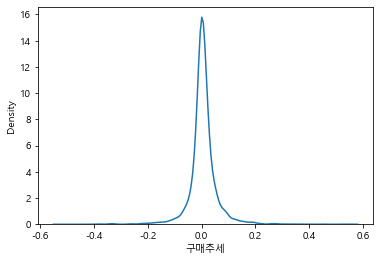

In [43]:
sns.kdeplot(features.구매추세)
plt.show()

**[7]** 성별

In [44]:
f = df.groupby('ID')['성별'].max()
features = features.merge(f, how = 'left', on='ID')

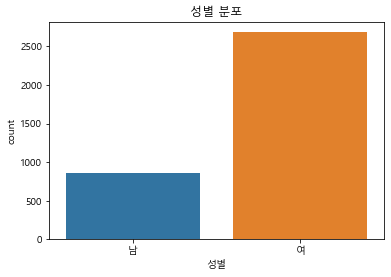

In [45]:
sns.countplot(data = features, x = '성별')
plt.title('성별 분포')
plt.show()

**[8]** 최근구매월

In [46]:
f = df.groupby('ID')['구매일자'].agg(lambda x : x.dt.month.max()).reset_index().rename(columns = {'구매일자':'최근구매월'})
features = features.merge(f, how = 'left', on='ID')

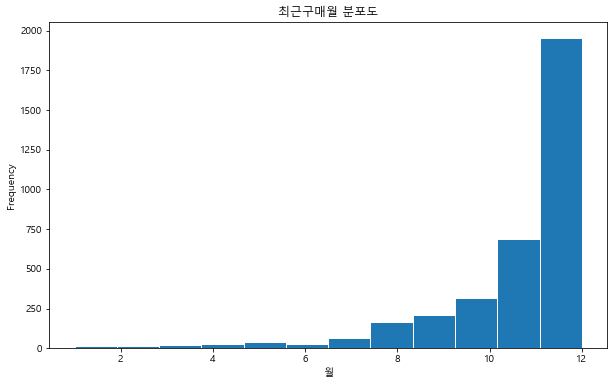

In [47]:
features.최근구매월.plot.hist(edgecolor = 'w', figsize = (10,6), bins = 12)
plt.title('최근구매월 분포도')
plt.xlabel('월')
plt.show()

#### 다 만든 features 정보 확인

In [48]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3541 entries, 0 to 3540
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       3541 non-null   int64  
 1   총구매액     3541 non-null   int64  
 2   구매건수     3541 non-null   int64  
 3   내점일수     3541 non-null   int64  
 4   구매주기     3541 non-null   int64  
 5   주말방문율    3541 non-null   float64
 6   방문당구매액   3541 non-null   int32  
 7   방문당구매건수  3541 non-null   float64
 8   주구매시간    3541 non-null   int64  
 9   최고가상품값   3541 non-null   int32  
 10  구매추세     3541 non-null   float64
 11  성별       3541 non-null   object 
 12  최근구매월    3541 non-null   int64  
dtypes: float64(3), int32(2), int64(7), object(1)
memory usage: 359.6+ KB


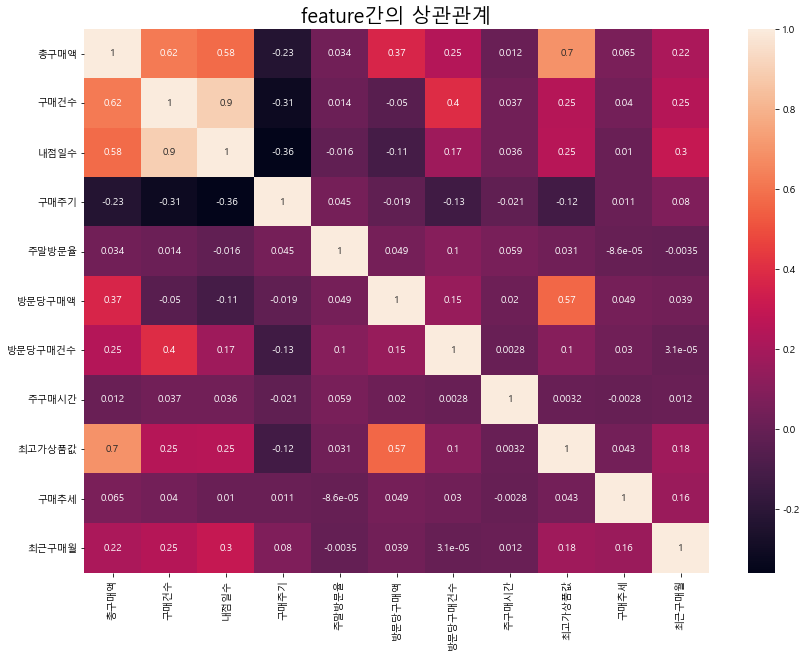

In [49]:
# feature 간의 유사성 파악
plt.figure(figsize = (14,10))
sns.heatmap(features.iloc[:, 1:].corr(), annot = True)
plt.title('feature간의 상관관계',fontsize=20)
plt.show()

## 2.Segementing

In [50]:
group = pd.DataFrame({'ID' : features.ID.unique()}); group

,ID
0,478207946
1,479806984
2,94790213
3,656026338
4,433076833
...,...
3536,154314532
3537,416998709
3538,168692065
3539,955481370


### 1. 구매금액(P)

* 총 구매액과 최고가 상품값으로 구매금액 측면에서의 점수 부여

#### 총 구매액  점수

In [51]:
# 총 구매액 사분위수 파악
features.quantile([.25, .5, .75])['총구매액']

0.25     386000.0
0.50    1076000.0
0.75    2526000.0
Name: 총구매액, dtype: float64

In [52]:
# 4점
# 총구매액 >= 2526000

# 3점
# 1076000 <= 총구매액 < 2526000

# 2점
# 386000 <= 총구매액 < 1076000

# 1점
# 총구매액

In [53]:
p4 = features.query('총구매액 >= 2526000')
p4['총구매액점수'] = 4

p3 = features.query('1076000 <= 총구매액 < 2526000')
p3['총구매액점수'] = 3
                      
p2 = features.query('386000 <= 총구매액 < 1076000')
p2['총구매액점수'] = 2
                      
p1 = features.query('총구매액 < 386000')
p1['총구매액점수'] = 1

<ipython-input-53-3b89549735ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p4['총구매액점수'] = 4
<ipython-input-53-3b89549735ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3['총구매액점수'] = 3
<ipython-input-53-3b89549735ac>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [54]:
pp = pd.concat([p1, p2, p3, p4])

In [55]:
pp

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,최고가상품값,구매추세,성별,최근구매월,총구매액점수
0,478207946,320000,4,4,68,0.25,80000,1.0,17,118000,0.01,남,12,1
1,479806984,318000,5,3,64,0.20,106000,1.7,12,120000,-0.02,남,12,1
2,94790213,216000,7,6,51,0.00,36000,1.2,17,35000,-0.00,남,12,1
3,656026338,29000,3,3,80,0.00,9667,1.0,16,13000,-0.00,남,9,1
7,670304024,338000,3,2,0,0.00,169000,1.5,15,266000,0.01,남,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464,439625214,2678000,6,4,17,0.50,669500,1.5,16,1251000,-0.01,남,10,4
3483,677130914,6195000,9,5,16,0.00,1239000,1.8,16,1687000,0.00,여,12,4
3491,213913709,2962000,3,2,7,0.00,1481000,1.5,17,2309000,0.01,여,11,4
3502,975367130,3140000,8,4,11,0.62,785000,2.0,14,2507000,0.03,여,12,4


#### 최고가상품값 점수

In [56]:
features.최고가상품값.quantile([.25, .5, .75])

0.25    150000.0
0.50    384000.0
0.75    881000.0
Name: 최고가상품값, dtype: float64

In [57]:
# 4점
# 최고가상품값 >= 881000

# 3점
# 384000 <= 최고가상품값 <  881000

# 2점
# 150000 <= 최고가상품값 < 384000

# 1점
# 최고가상품값 < 150000

In [58]:
p4 = pp.query('최고가상품값 >= 881000')
p4['최고가상품값'] = 4

p3 = pp.query(' 384000 <= 최고가상품값 < 881000')
p3['최고가상품값'] = 3

p2 = pp.query('150000 <= 최고가상품값 <  384000')
p2['최고가상품값'] = 2

p1 = pp.query('최고가상품값 < 150000')
p1['최고가상품값'] = 1

<ipython-input-58-67c97b1dc591>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p4['최고가상품값'] = 4
<ipython-input-58-67c97b1dc591>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3['최고가상품값'] = 3
<ipython-input-58-67c97b1dc591>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [59]:
pp = pd.concat([p1, p2, p3, p4])

In [60]:
pp

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,최고가상품값,구매추세,성별,최근구매월,총구매액점수
0,478207946,320000,4,4,68,0.25,80000,1.0,17,1,0.01,남,12,1
1,479806984,318000,5,3,64,0.20,106000,1.7,12,1,-0.02,남,12,1
2,94790213,216000,7,6,51,0.00,36000,1.2,17,1,-0.00,남,12,1
3,656026338,29000,3,3,80,0.00,9667,1.0,16,1,-0.00,남,9,1
10,551136973,101000,3,3,44,0.33,33667,1.0,13,1,-0.00,남,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464,439625214,2678000,6,4,17,0.50,669500,1.5,16,4,-0.01,남,10,4
3483,677130914,6195000,9,5,16,0.00,1239000,1.8,16,4,0.00,여,12,4
3491,213913709,2962000,3,2,7,0.00,1481000,1.5,17,4,0.01,여,11,4
3502,975367130,3140000,8,4,11,0.62,785000,2.0,14,4,0.03,여,12,4


In [61]:
a = pp[['ID','총구매액점수','최고가상품값']]
group = pd.merge(group, a, how = 'left', on='ID')

In [62]:
group

,ID,총구매액점수,최고가상품값
0,478207946,1,1
1,479806984,1,1
2,94790213,1,1
3,656026338,1,1
4,433076833,3,1
...,...,...,...
3536,154314532,2,3
3537,416998709,1,1
3538,168692065,1,1
3539,955481370,3,4


In [63]:
# 4점
# 총구매점수 = 4
# 총구매점수 = 3 , 최고가상품값 = 3 or 4

# 3점
# 총구매액점수 = 3 , 최고가상품값 = 1 or 2
# 총구매액점수 = 2 , 최고가상품값 = 3 or 4

# 2점
# 총구매액점수 = 2 , 최고가상품값 = 1 or 2
# 총구매액점수 = 1 , 최고가상품값 = 3 or 4

# 1점
# 총구매액점수 = 1 , 최고가상품값 = 1 or 2

In [64]:
p4 = group.query('총구매액점수 == 4')
p4_1 = group.query('총구매액점수 == 3').query('최고가상품값 == 3 or 최고가상품값 == 4')
p4 = pd.concat([p4, p4_1])
p4['p_score'] = 4

p3 = group.query('총구매액점수 == 3').query('최고가상품값 == 1 or 최고가상품값 == 2')
p3_1 = group.query('총구매액점수 == 2').query('최고가상품값 == 3 or 최고가상품값 == 4')
p3 = pd.concat([p3, p3_1])
p3['p_score'] = 3

p2 = group.query('총구매액점수 == 2').query('최고가상품값 == 1 or 최고가상품값 == 2')
p2_1 = group.query('총구매액점수 == 1').query('최고가상품값 == 3 or 최고가상품값 == 4')
p2 = pd.concat([p2, p2_1])
p2['p_score'] = 2

p1 = group.query('총구매액점수 == 1').query('최고가상품값 == 1 or 최고가상품값 == 2')
p1['p_score'] = 1

group = pd.concat([p1, p2, p3, p4])

In [65]:
del pp['총구매액점수'], pp['최고가상품값'], group['총구매액점수'], group['최고가상품값']

In [66]:
group

,ID,p_score
0,478207946,1
1,479806984,1
2,94790213,1
3,656026338,1
7,670304024,1
...,...,...
3530,649789071,4
3531,524493815,4
3534,118963032,4
3535,164097706,4


### 2. 구매일(D)

* 구매주기와 구매추세 측면에서의 점수부여

In [67]:
features.구매주기.quantile([.25, .5, .75])

0.25    12.0
0.50    24.0
0.75    42.0
Name: 구매주기, dtype: float64

In [68]:
features.구매주기.max()

165

#### 구매주기 점수

In [69]:
# 4점
# 구매주기 : 1 ~ 12

# 3점
# 구매주기 : 13 ~ 24

# 2점
# 구매주기 : 25 ~ 42

# 1점
# 구매주기 : 43 ~ 165

# 구매주기가 0인 고객 중 12월에 구매한 고객의 구매주기 점수는 3으로 한다.
# 구매주기가 0인 고객 중 11월에 구매한 고객의 구매주기 점수는 2으로 한다.
# 구매주기가 0인 고객 중 11월 이전에 구매한 구객의 구매주기 점수는 1점으로 한다.

In [70]:
d4 = pp.query('1 <= 구매주기 <= 12')
d4['구매주기점수'] = 4

d3 = pp.query('13 <= 구매주기 <= 24')
d3_1 = pp.query('구매주기 == 0 & 최근구매월 == 12')
d3 = pd.concat([d3, d3_1])
d3['구매주기점수'] = 3

d2 = pp.query('25 <= 구매주기 <= 42')
d2_1 = pp.query('구매주기 == 0 & 최근구매월 == 11')
d2 = pd.concat([d2, d2_1])
d2['구매주기점수'] = 2

d1 = pp.query('43 <= 구매주기 <= 165')
d1_1 = pp.query('구매주기 == 0 & 최근구매월 < 11')
d1 = pd.concat([d1, d1_1])
d1['구매주기점수'] = 1


dd = pd.concat([d1, d2, d3, d4])

<ipython-input-70-83ef2d518652>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d4['구매주기점수'] = 4


In [71]:
dd

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,구매추세,성별,최근구매월,구매주기점수
0,478207946,320000,4,4,68,0.25,80000,1.0,17,0.01,남,12,1
1,479806984,318000,5,3,64,0.20,106000,1.7,12,-0.02,남,12,1
2,94790213,216000,7,6,51,0.00,36000,1.2,17,-0.00,남,12,1
3,656026338,29000,3,3,80,0.00,9667,1.0,16,-0.00,남,9,1
10,551136973,101000,3,3,44,0.33,33667,1.0,13,-0.00,남,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,287341160,12257000,214,72,4,0.61,170236,3.0,18,0.02,남,12,4
3446,806781930,4578000,26,13,8,0.41,352154,2.0,15,-0.03,여,11,4
3491,213913709,2962000,3,2,7,0.00,1481000,1.5,17,0.01,여,11,4
3502,975367130,3140000,8,4,11,0.62,785000,2.0,14,0.03,여,12,4


#### 구매추세 점수

In [72]:
features.구매추세.quantile([.25, .5, .75])

0.25   -0.01
0.50    0.00
0.75    0.02
Name: 구매추세, dtype: float64

In [73]:
features.구매추세.min(), features.구매추세.max()

(-0.52, 0.55)

In [74]:
# 4점
# 구매추세 0.02 ~  0.55

# 3점
# 구매추세 0.00 ~ 0.02

# 2점
# 구매추세 -0.01 ~ 0.00

# 1점
# 구매추세 -0.52 ~ -0.01

In [75]:
d4 = dd.query('0.02 <= 구매추세')
d4['구매추세점수'] = 4

d3 = dd.query('0.00 <= 구매추세 < 0.02')
d3['구매추세점수'] = 3

d2 = dd.query('-0.01 <= 구매추세 < 0.00')
d2['구매추세점수'] = 2

d1 = dd.query('구매추세 < -0.01')
d1['구매추세점수'] = 1

dd = pd.concat([d1, d2, d3, d4])

<ipython-input-75-2d01b909857d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d4['구매추세점수'] = 4
<ipython-input-75-2d01b909857d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3['구매추세점수'] = 3
<ipython-input-75-2d01b909857d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [76]:
dd

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,구매추세,성별,최근구매월,구매주기점수,구매추세점수
1,479806984,318000,5,3,64,0.20,106000,1.7,12,-0.02,남,12,1,1
17,536617656,87000,11,5,71,0.00,17400,2.2,11,-0.02,여,12,1,1
30,961035519,138000,8,4,56,0.00,34500,2.0,14,-0.02,여,9,1,1
45,644403176,167000,5,2,91,0.00,83500,2.5,19,-0.02,남,7,1,1
548,176641279,87000,5,2,87,1.00,43500,2.5,15,-0.03,여,12,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,487482414,8770000,89,40,8,0.47,219250,2.2,14,0.05,여,12,4,4
3269,567081866,9549000,93,42,8,0.25,227357,2.2,13,0.08,여,12,4,4
3342,287341160,12257000,214,72,4,0.61,170236,3.0,18,0.02,남,12,4,4
3502,975367130,3140000,8,4,11,0.62,785000,2.0,14,0.03,여,12,4,4


In [77]:
d_score = dd[['ID', '구매주기점수','구매추세점수']]
group = group.merge(d_score, how = 'left' ,on = 'ID')

In [78]:
group

,ID,p_score,구매주기점수,구매추세점수
0,478207946,1,1,3
1,479806984,1,1,1
2,94790213,1,1,3
3,656026338,1,1,3
4,670304024,1,2,3
...,...,...,...,...
3536,649789071,4,4,3
3537,524493815,4,4,4
3538,118963032,4,4,4
3539,164097706,4,1,4


####  - 구매주기 점수와 구매추세 점수에 따른 최종 D점수

In [79]:
# 4점
# 구매주기 = 4, 구매추세 = 3 or 4
# 구매주기 = 3, 구매추세 = 4

# 3점
# 구매주기 = 4, 구매추세 = 2 
# 구매주기 = 3, 구매추세 = 3 or 2 
# 구매주기 = 2, 구매추세 = 4 

# 2점
# 구매주기 = 4, 구매추세 = 1
# 구매주기 = 3, 구매추세 = 1
# 구매주기 = 2, 구매추세 = 3 or 2 
# 구매주기 = 1, 구매추세 = 4 

# 1점
# 구매주기 = 2, 구매추세 = 1
# 구매주기 = 1, 구매추세 = 1 or 2 or 3

# 0점
# 구매주기 = 0

In [80]:
d4 = group.query('구매주기점수 == 4').query('구매추세점수 == 3 or 구매추세점수 == 4')
d4_1 = group.query('구매주기점수 == 3 and 구매추세점수 == 4')
d4 = pd.concat([d4, d4_1])
d4['d_score'] = 4

d3 = group.query('구매주기점수 == 4 and 구매추세점수 == 2')
d3_1 = group.query('구매주기점수 == 3').query('구매추세점수 == 2 or 구매추세점수 == 3')
d3_2 = group.query('구매주기점수 == 2 and 구매추세점수 == 4')
d3 = pd.concat([d3, d3_1, d3_2])
d3['d_score'] = 3

d2 = group.query('구매주기점수 == 4 and 구매추세점수 == 1')
d2_1 = group.query('구매주기점수 == 3 and 구매추세점수 == 1')
d2_2 = group.query('구매주기점수 == 2').query('구매추세점수 == 2 or 구매추세점수 == 3')
d2_3 = group.query('구매주기점수 == 1 and 구매추세점수 == 4')
d2 = pd.concat([d2, d2_1, d2_2, d2_3])
d2['d_score'] = 2

d1 = group.query('구매주기점수 == 2 and 구매추세점수 == 1')
d1_1 = group.query('구매주기점수 == 1').query('구매추세점수 == 1 or 구매추세점수 == 2 or 구매추세점수 == 3')
d1 = pd.concat([d1, d1_1])
d1['d_score'] = 1

d0 = group.query('구매주기점수 == 0')
d0['d_score'] = 0

group = pd.concat([d0, d1, d2, d3, d4])

In [81]:
del dd['구매주기점수'], dd['구매추세점수'], group['구매주기점수'], group['구매추세점수']

In [82]:
group

,ID,p_score,d_score
10,89988341,1,1
32,221241742,1,1
43,263924850,1,1
65,55844757,1,1
111,497983708,1,1
...,...,...,...
3485,955007680,4,4
3511,712079895,4,4
3523,595251402,4,4
3528,7147192,4,4


### 3. 구매건수(C)

* 1회 방문 당 구매건수와 구매건수 측면에서의 점수부여

#### 1회 방문 당 구매건수 점수

In [83]:
dd.groupby('ID')['방문당구매건수'].mean().quantile([.25, .5, .75])

0.25    1.4
0.50    1.9
0.75    2.4
Name: 방문당구매건수, dtype: float64

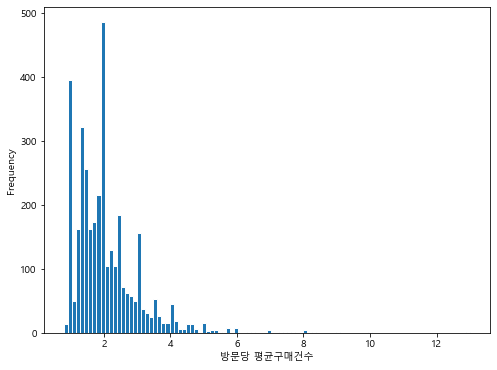

In [84]:
# 해당 사분위수 신뢰성 검정을 위한 그래프화 -> 0~2 사이에 대부분의 고객들이 분포
dd.groupby('ID')['방문당구매건수'].mean().sort_values(ascending = False).plot.hist(figsize = (8,6), bins = 100, edgecolor = 'w')
plt.xlabel('방문당 평균구매건수')
plt.show()

In [85]:
dd.groupby('ID')['방문당구매건수'].mean().min() , dd.groupby('ID')['방문당구매건수'].mean().max()

(0.8, 13.0)

In [86]:
# 4점
# 방문당구매건수: 2.4 ~ 13.0

# 3점
# 방문당구매건수 : 1.9 ~ 2.4

# 2점
# 방문당구매건수 : 1.4 ~ 1.9

# 1점
# 방문당구매건수 : 0.8 ~ 1.4

In [87]:
c4 = dd.query('방문당구매건수 >= 2.4')
c4['방문당구매건수점수'] = 4

c3 = dd.query('1.9 <= 방문당구매건수 < 2.4')
c3['방문당구매건수점수'] = 3

c2 = dd.query('1.4 <= 방문당구매건수 < 1.9')
c2['방문당구매건수점수'] = 2

c1 = dd.query('방문당구매건수 < 1.4')
c1['방문당구매건수점수'] = 1

dd = pd.concat([c1, c2, c3, c4])

<ipython-input-87-2581552c8900>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c4['방문당구매건수점수'] = 4
<ipython-input-87-2581552c8900>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c3['방문당구매건수점수'] = 3
<ipython-input-87-2581552c8900>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [88]:
dd

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,구매추세,성별,최근구매월,방문당구매건수점수
886,45707924,124000,4,3,61,0.00,41333,1.3,20,-0.02,여,8,1
2143,845545581,189000,4,3,61,0.50,63000,1.3,16,-0.02,여,7,1
2579,497340157,124000,4,3,53,1.00,41333,1.3,18,-0.02,여,8,1
2575,564380353,410000,8,6,51,0.30,68333,1.3,16,-0.05,여,11,1
127,138783977,485000,8,7,44,0.38,69286,1.1,16,-0.02,여,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,56540772,3186000,14,4,4,0.00,796500,3.5,18,0.11,여,12,4
2688,989469599,4860000,190,45,2,0.38,108000,4.2,15,0.55,남,12,4
3028,848836855,6335000,126,32,10,0.24,197969,3.9,15,0.04,여,12,4
3174,803973887,10844000,21,6,10,0.64,1807333,3.5,15,0.09,여,12,4


#### 총 구매건수 점수

In [89]:
dd.groupby('ID')['구매건수'].mean().quantile([.25, .5, .75]).astype(int)

0.25     5
0.50    12
0.75    30
Name: 구매건수, dtype: int32

In [90]:
dd.groupby('ID')['구매건수'].mean().min() , dd.groupby('ID')['구매건수'].mean().max()

(1, 634)

In [91]:
# 4점
# 구매건수점수 : 30 ~ 634

# 3점
# 구매건수점수 : 12 ~ 30

# 2점
# 구매건수점수 : 5~ 12

# 1점
# 구매건수점수 : 1 ~ 5

In [92]:
c4 = dd.query('구매건수 >= 30')
c4['구매건수점수'] = 4

c3 = dd.query('12 <= 구매건수 < 30')
c3['구매건수점수'] = 3

c2 = dd.query(' 5 <= 구매건수 < 12')
c2['구매건수점수'] = 2

c1 = dd.query('구매건수 < 5')
c1['구매건수점수'] = 1

cc = pd.concat([c1, c2, c3, c4])

<ipython-input-92-30942fdedf02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c4['구매건수점수'] = 4
<ipython-input-92-30942fdedf02>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c3['구매건수점수'] = 3
<ipython-input-92-30942fdedf02>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [93]:
cc

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,구매추세,성별,최근구매월,방문당구매건수점수,구매건수점수
886,45707924,124000,4,3,61,0.00,41333,1.3,20,-0.02,여,8,1,1
2143,845545581,189000,4,3,61,0.50,63000,1.3,16,-0.02,여,7,1,1
2579,497340157,124000,4,3,53,1.00,41333,1.3,18,-0.02,여,8,1,1
3345,23205551,1104000,4,3,43,0.25,368000,1.3,15,-0.02,여,11,1,1
90,221241742,128000,4,3,29,0.00,42667,1.3,16,-0.02,남,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,471807073,12566000,94,37,9,0.35,339622,2.5,17,0.07,여,12,4,4
2509,774406229,23169000,91,34,10,0.13,681441,2.7,14,0.16,여,12,4,4
2688,989469599,4860000,190,45,2,0.38,108000,4.2,15,0.55,남,12,4,4
3028,848836855,6335000,126,32,10,0.24,197969,3.9,15,0.04,여,12,4,4


In [94]:
c_score = cc[['ID','방문당구매건수점수','구매건수점수']]
group = group.merge(c_score, how='left')

####  - 방문당 구매건수 점수와 구매건수 점수에 따른 최종 C 점수

In [95]:
# 구매건수 = 4, 방문당구매건수 = 4/3   :   4
# 구매건수 = 3, 방문당구매건수 = 1   :   4

# 구매건수 = 4, 방문당구매건수 = 3/4   :   3
# 구매건수 = 3, 방문당구매건수 = 2/3   :   3

# 구매건수 = 3, 방문당구매건수 = 4   :   2
# 구매건수 = 2, 방문당구매건수 = 1/2/3   :   2

# 구매건수 = 2, 방문당구매건수 = 4   :   1
# 구매건수 = 1   :   1

In [96]:
c4 = group.query('구매건수점수 == 4').query('방문당구매건수점수 == 4 or 방문당구매건수점수 == 3')
c4_1 = group.query('구매건수점수 == 3 and 방문당구매건수점수 == 4')
c4 = pd.concat([c4, c4_1])
c4['c_score'] = 4

c3 = group.query('구매건수점수 == 4').query('방문당구매건수점수 == 1 or 방문당구매건수점수 == 2')
c3_1 = group.query('구매건수점수 == 3').query('방문당구매건수점수 == 3 or 방문당구매건수점수 == 2')
c3 = pd.concat([c3, c3_1])
c3['c_score'] = 3

c2 = group.query('구매건수점수 == 3 and 방문당구매건수점수 == 1')
c2_1 = group.query('구매건수점수 == 2').query('방문당구매건수점수 == 4 or 방문당구매건수점수 == 3 or 방문당구매건수점수 == 2')
c2 = pd.concat([c2, c2_1])
c2['c_score'] = 2

c1 = group.query('구매건수점수 == 2 and 방문당구매건수점수 == 1')
c1_1 = group.query('구매건수점수 == 1')
c1 = pd.concat([c1, c1_1])
c1['c_score'] = 1

group = pd.concat([c1, c2, c3, c4])

In [97]:
del cc, group['구매건수점수'], group['방문당구매건수점수']

In [98]:
group

,ID,p_score,d_score,c_score
6,791647304,1,1,1
13,888743928,1,1,1
16,228039119,1,1,1
24,516127173,1,1,1
29,867835182,2,1,1
...,...,...,...,...
3445,700751661,4,4,4
3475,140737745,4,4,4
3477,909877789,4,4,4
3517,447422691,4,4,4


In [99]:
group['PDC'] = group['p_score'].map(str) + group['d_score'].map(str) + group['c_score'].map(str)

In [100]:
group.PDC.nunique()

64

In [101]:
# P = 가격대별 구매율, 상품값범위
# D = 구매주기, 구매추세
# C = 구매건수, 방문당구매건수

In [102]:
weights = [4, 4, 2]
group['PDCscore'] = weights[0] * group['p_score'] + weights[1] * group['d_score'] + weights[2] * group['c_score']
group

,ID,p_score,d_score,c_score,PDC,PDCscore
6,791647304,1,1,1,111,10
13,888743928,1,1,1,111,10
16,228039119,1,1,1,111,10
24,516127173,1,1,1,111,10
29,867835182,2,1,1,211,14
...,...,...,...,...,...,...
3445,700751661,4,4,4,444,40
3475,140737745,4,4,4,444,40
3477,909877789,4,4,4,444,40
3517,447422691,4,4,4,444,40


# PDC기준 최종 Customer Segment

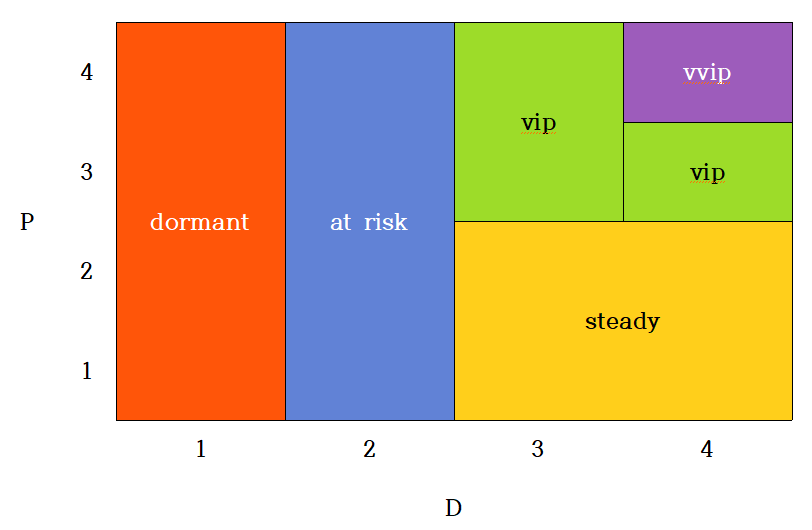

In [103]:
seg_map = {
    r'[1-4]1': 'dormant',
    r'[1-4]2': 'at risk',
    r'43': 'vip',
    r'34': 'vip',
    r'33': 'vip',
    r'44': 'vvip',
    r'[1-2]3': 'steady',
    r'[1-2]4': 'steady'
}

In [104]:
seg_map

{'[1-4]1': 'dormant',
 '[1-4]2': 'at risk',
 '43': 'vip',
 '34': 'vip',
 '33': 'vip',
 '44': 'vvip',
 '[1-2]3': 'steady',
 '[1-2]4': 'steady'}

In [105]:
group['segment'] = group['d_score'].map(str) + group['p_score'].map(str)
group['segment'] = group['segment'].replace(seg_map, regex = True)

#### features['segment'] 삽입

In [106]:
f = group.groupby('ID')['segment'].max()
features = features.merge(f, how = 'left', on='ID')

In [107]:
f

ID
741463       at risk
909249        steady
1065068          vip
1310410      dormant
1387032      dormant
              ...   
998623524        vip
999024423    dormant
999184958     steady
999375162        vip
999494396    dormant
Name: segment, Length: 3541, dtype: object

### segment 세부 분류

In [108]:
features.query('segment == "vvip"').총구매액.quantile([.25,.5,.75])

0.25    2487000.0
0.50    3844500.0
0.75    6337250.0
Name: 총구매액, dtype: float64

In [109]:
features.query('segment == "vip"').총구매액.quantile([.25,.5,.75])

0.25    1233500.0
0.50    1830000.0
0.75    3199750.0
Name: 총구매액, dtype: float64

In [110]:
f = features.query('segment == "steady" & 총구매액 >= 3734750')
f['segment'] = f.총구매액.apply(lambda x : 'vvip' if x > 6337250 else 'vip' )

f_ID = list(f.ID.values)
features_a = features.query('ID != @f_ID')

features = pd.concat([f,features_a]); features

pdc_a = features.groupby('ID')['segment'].max()
df = df.merge(pdc_a, how = 'left', on='ID')


<ipython-input-110-84d0fcbf2ceb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['segment'] = f.총구매액.apply(lambda x : 'vvip' if x > 6337250 else 'vip' )


In [111]:
features

,ID,총구매액,구매건수,내점일수,구매주기,주말방문율,방문당구매액,방문당구매건수,주구매시간,최고가상품값,구매추세,성별,최근구매월,segment
9,306915014,14783000,318,96,3,0.53,153990,3.3,16,338000,-0.38,여,12,vvip
24,47655351,5308000,60,31,11,0.11,171226,1.9,14,1110000,-0.02,여,12,vip
29,701411064,6947000,44,27,11,0.62,257296,1.6,15,1687000,-0.04,여,12,vvip
31,323958548,21525000,166,36,9,0.55,597917,4.6,16,3028000,-0.02,여,12,vvip
51,257364199,10446000,55,30,12,0.40,348200,1.8,13,1785000,-0.04,남,12,vvip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,154314532,846000,3,2,10,0.00,423000,1.5,16,684000,0.02,남,12,vip
3537,416998709,41000,3,1,0,1.00,41000,3.0,19,21000,0.02,남,12,dormant
3538,168692065,10000,2,1,0,0.00,10000,2.0,19,9000,0.02,여,12,dormant
3539,955481370,1219000,4,2,6,0.00,609500,2.0,19,1057000,0.03,여,12,vvip


### segment별 비교

* 각 segment별 고객의 수

In [112]:
# segment 별 고객 수
features.groupby('segment')['ID'].agg(lambda x : x.count() / features.ID.count()).reset_index().rename(columns = {'ID' : '고객비율'})

,segment,고객비율
0,at risk,0.167184
1,dormant,0.247670
2,steady,0.255860
3,vip,0.173962
4,vvip,0.155323


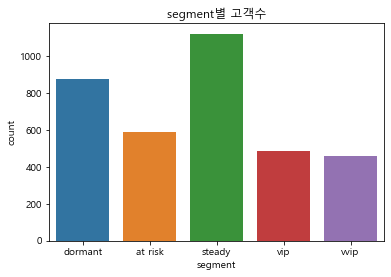

In [113]:
sns.countplot(data = group, x ='segment')
plt.title('segment별 고객수')
plt.show()

* 각 segment별 구매금액

In [114]:
# segment 별 구매비율
features.groupby('segment')['총구매액'].agg(lambda x : x.sum() / features.총구매액.sum()).reset_index().rename(columns = {'총구매액' : '구매금액비율'})

,segment,구매금액비율
0,at risk,0.048181
1,dormant,0.020108
2,steady,0.202286
3,vip,0.253740
4,vvip,0.475684


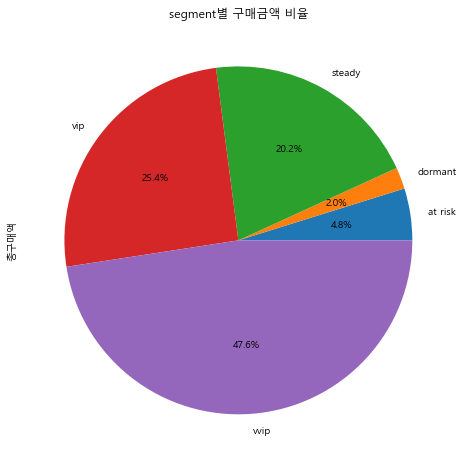

In [115]:
features.groupby('segment')['총구매액'].sum().plot.pie(figsize = (12,8), autopct = '%.1f%%')
plt.title('segment별 구매금액 비율')
plt.show()

* 각 segment별 상품중분류별 구매금액

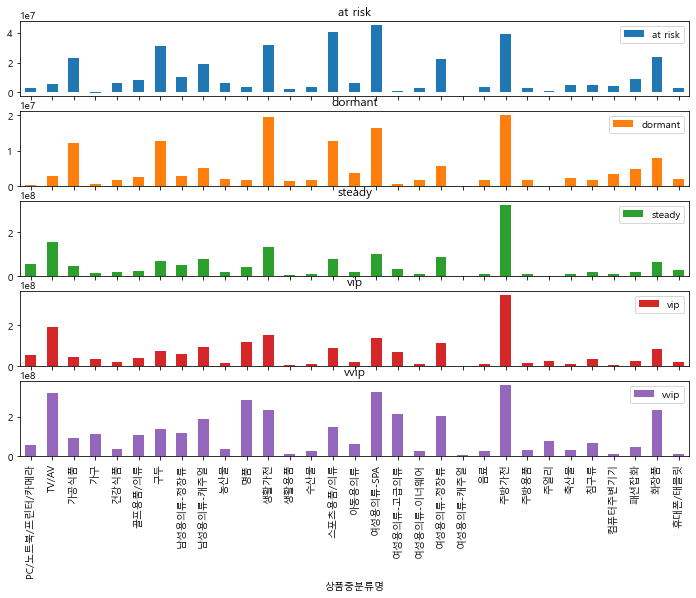

In [116]:
price = pd.pivot_table(df, index = 'segment', columns = '상품중분류명', values = '구매금액', 
                       aggfunc = np.sum, fill_value = 0)
price.T.plot.bar(subplots = True, figsize = (12,8))
plt.show()

* 각 segment별 상품중분류 구매량

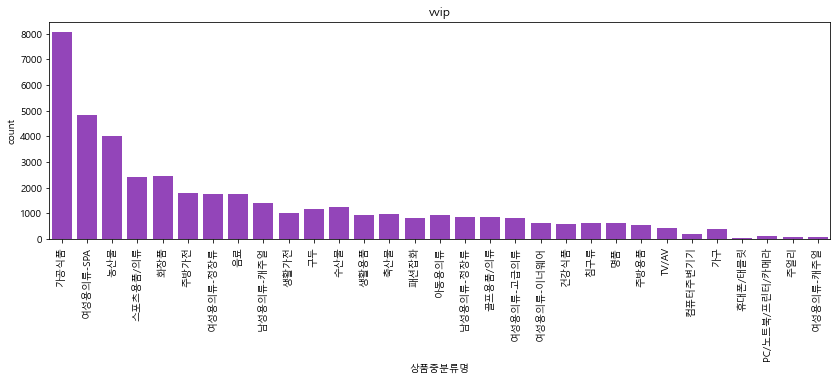

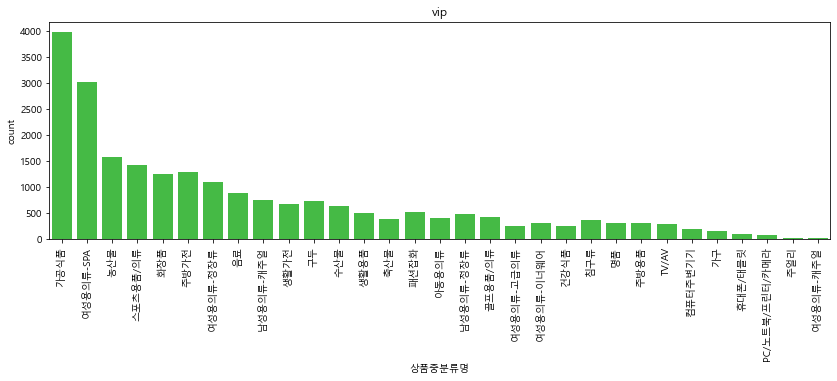

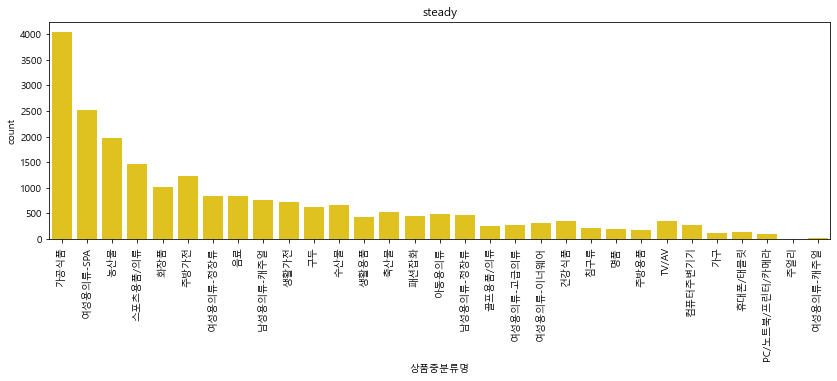

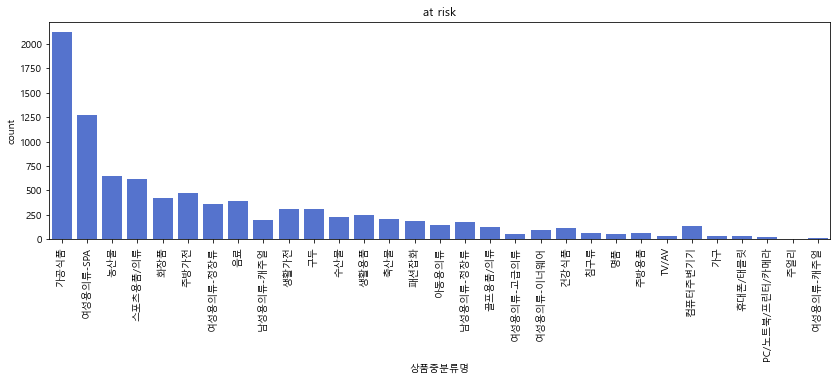

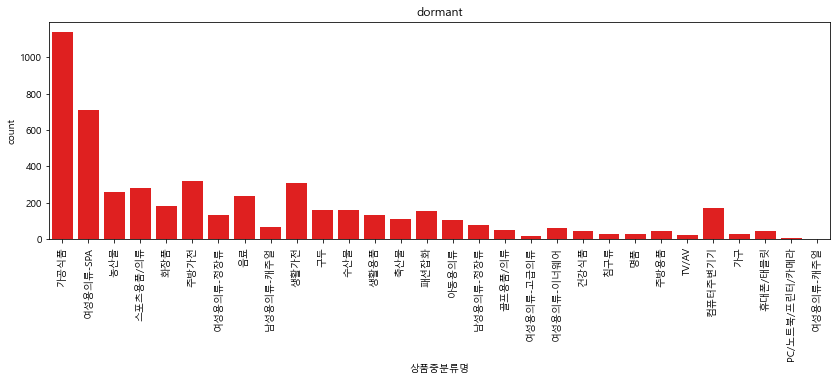

In [117]:
dfs=df.groupby('상품중분류명')['ID'].agg([("총갯수","count")]).reset_index()
dfs=pd.merge(df,dfs)
dfs=dfs.sort_values(by='총갯수',ascending=False)
plt.figure(figsize = (14,4))
sns.countplot(data = dfs.query('segment == "vvip"'), x = '상품중분류명', color = 'darkorchid')
plt.title('vvip')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (14,4))
sns.countplot(data = dfs.query('segment == "vip"'), x = '상품중분류명', color = 'limegreen')
plt.title('vip')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (14,4))
sns.countplot(data = dfs.query('segment == "steady"'), x = '상품중분류명', color = 'gold')
plt.title('steady')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (14,4))
sns.countplot(data = dfs.query('segment == "at risk"'), x = '상품중분류명', color = 'royalblue')
plt.title('at risk')
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (14,4))
sns.countplot(data = dfs.query('segment == "dormant"'), x = '상품중분류명', color = 'red')
plt.title('dormant')
plt.xticks(rotation = 90)
plt.show()

* 각 segment별 구매지역 별 구매금액

In [118]:
state = pd.pivot_table(df, index = '구매지역',columns = 'segment', values = '구매금액', aggfunc =  np.sum, fill_value = 0)

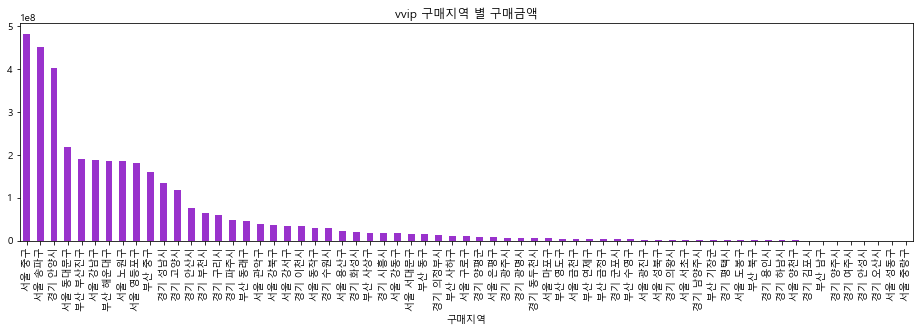

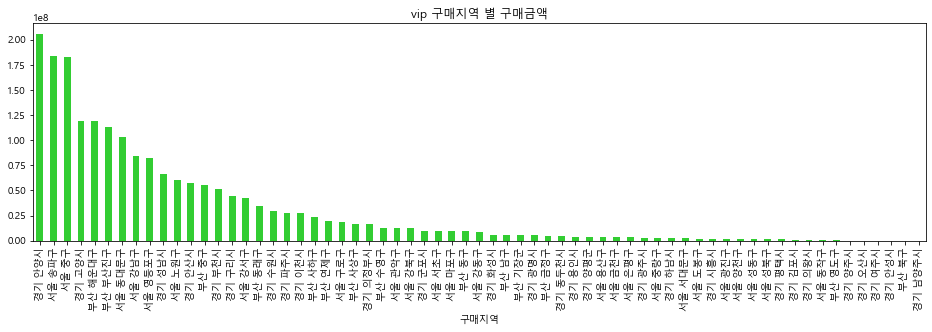

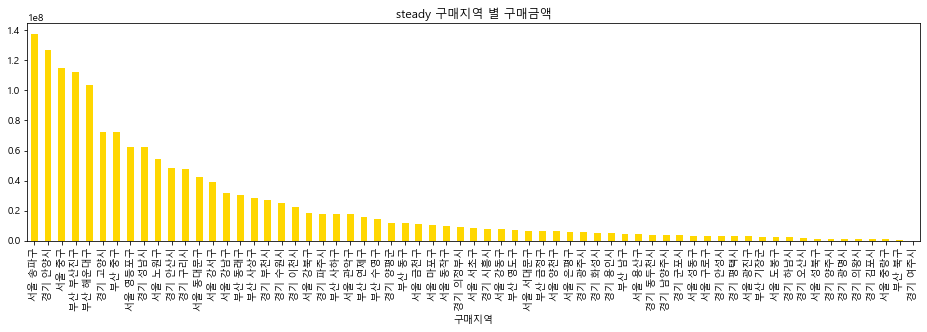

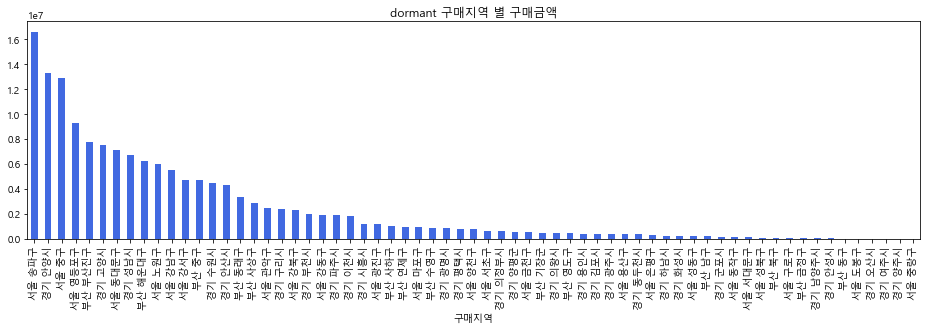

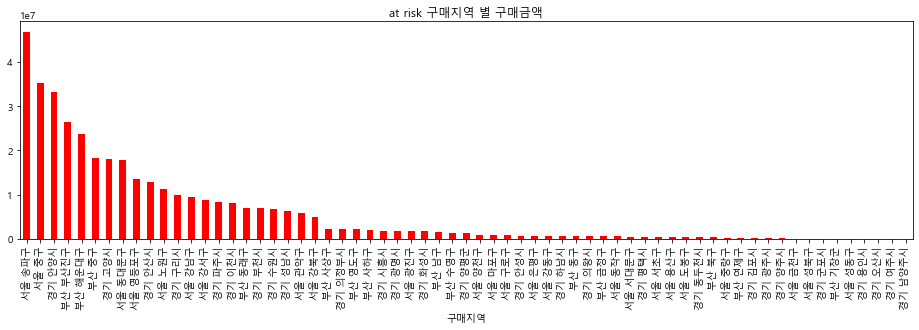

In [119]:
state.iloc[:,4].sort_values(ascending = False).plot.bar(figsize = (16,4),color = 'darkorchid')
plt.title('vvip 구매지역 별 구매금액')
plt.show()

state.iloc[:,3].sort_values(ascending = False).plot.bar(figsize = (16,4), color = 'limegreen')
plt.title('vip 구매지역 별 구매금액')
plt.show()

state.iloc[:,2].sort_values(ascending = False).plot.bar(figsize = (16,4),color = 'gold')
plt.title('steady 구매지역 별 구매금액')
plt.show()

state.iloc[:,1].sort_values(ascending = False).plot.bar(figsize = (16,4), color = 'royalblue')
plt.title('dormant 구매지역 별 구매금액')
plt.show()

state.iloc[:,0].sort_values(ascending = False).plot.bar(figsize = (16,4), color = 'red')
plt.title('at risk 구매지역 별 구매금액')
plt.show()

* 구매지역별 주요구매상품 (TOP 5)

In [120]:
a = pd.pivot_table(df, index = '상품중분류명', columns = '구매지역', values = '구매금액', aggfunc = np.sum, 
                   fill_value = 0)

In [121]:
local = list(df.구매지역.sort_values().unique())

In [122]:
qq=[list(a.sort_values(by=i, ascending = False).reset_index().상품중분류명.values[:5]) for i in local]

In [123]:
list_df = pd.DataFrame(local).rename(columns = {0 : '구매지역'})

In [124]:
c = pd.DataFrame(qq)

In [125]:
local_pd = pd.concat([list_df, c], axis = 1)
local_pd.columns = ['구매지역','1위','2위','3위','4위','5위']
local_pd

,구매지역,1위,2위,3위,4위,5위
0,경기 고양시,주방가전,여성용의류-SPA,TV/AV,여성용의류-고급의류,생활가전
1,경기 광명시,주방가전,TV/AV,스포츠용품/의류,구두,여성용의류-SPA
2,경기 광주시,TV/AV,주방가전,생활가전,휴대폰/태블릿,컴퓨터주변기기
3,경기 구리시,주방가전,여성용의류-정장류,남성용의류-캐주얼,여성용의류-SPA,스포츠용품/의류
4,경기 군포시,주방가전,생활가전,TV/AV,PC/노트북/프린터/카메라,컴퓨터주변기기
...,...,...,...,...,...,...
60,서울 영등포구,여성용의류-SPA,여성용의류-정장류,여성용의류-고급의류,구두,스포츠용품/의류
61,서울 용산구,주방가전,TV/AV,생활가전,컴퓨터주변기기,주방용품
62,서울 은평구,주방가전,생활가전,TV/AV,PC/노트북/프린터/카메라,컴퓨터주변기기
63,서울 중구,명품,화장품,여성용의류-SPA,여성용의류-고급의류,여성용의류-정장류


* 각 segment별 성비

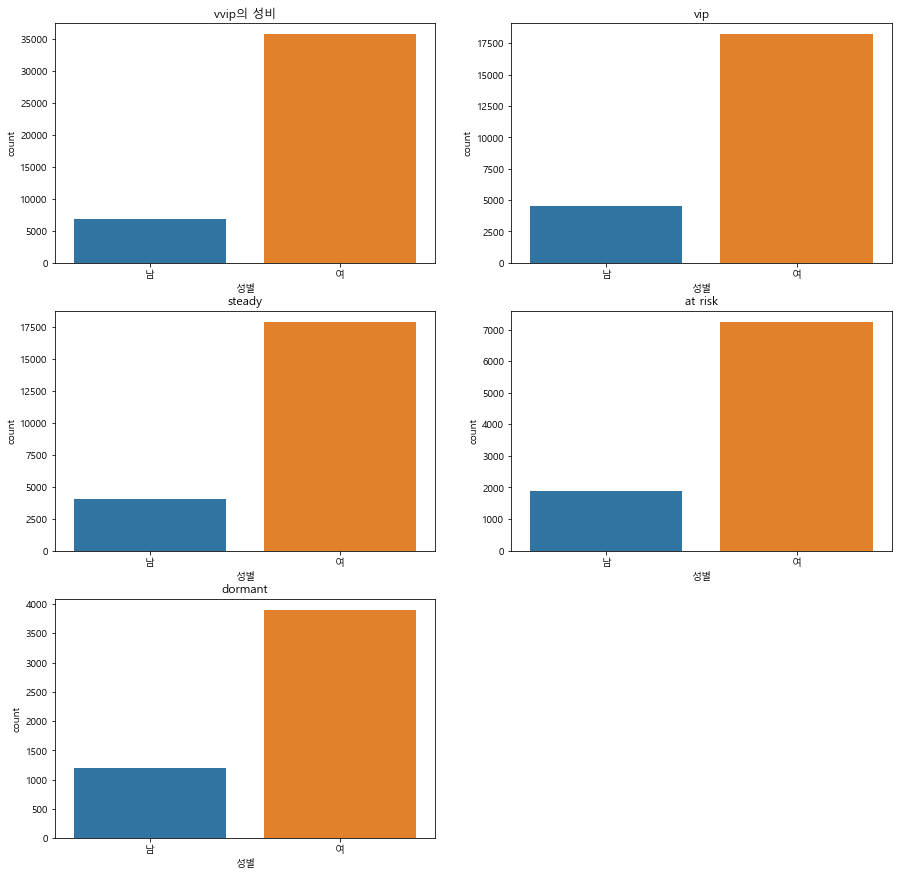

In [126]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
sns.countplot(data = df.query('segment == "vvip"').sort_values(by='성별'), x = '성별')
plt.title('vvip의 성비')

plt.subplot(3,2,2)
sns.countplot(data = df.query('segment == "vip"').sort_values(by='성별'), x = '성별')
plt.title('vip')

plt.subplot(3,2,3)
sns.countplot(data = df.query('segment == "steady"').sort_values(by='성별'), x = '성별')
plt.title('steady')

plt.subplot(3,2,4)
sns.countplot(data = df.query('segment == "at risk"').sort_values(by='성별'), x = '성별')
plt.title('at risk')

plt.subplot(3,2,5)
sns.countplot(data = df.query('segment == "dormant"').sort_values(by='성별'), x = '성별')
plt.title('dormant')
plt.show()

* 각 segment별 성비별 구매금액 비율

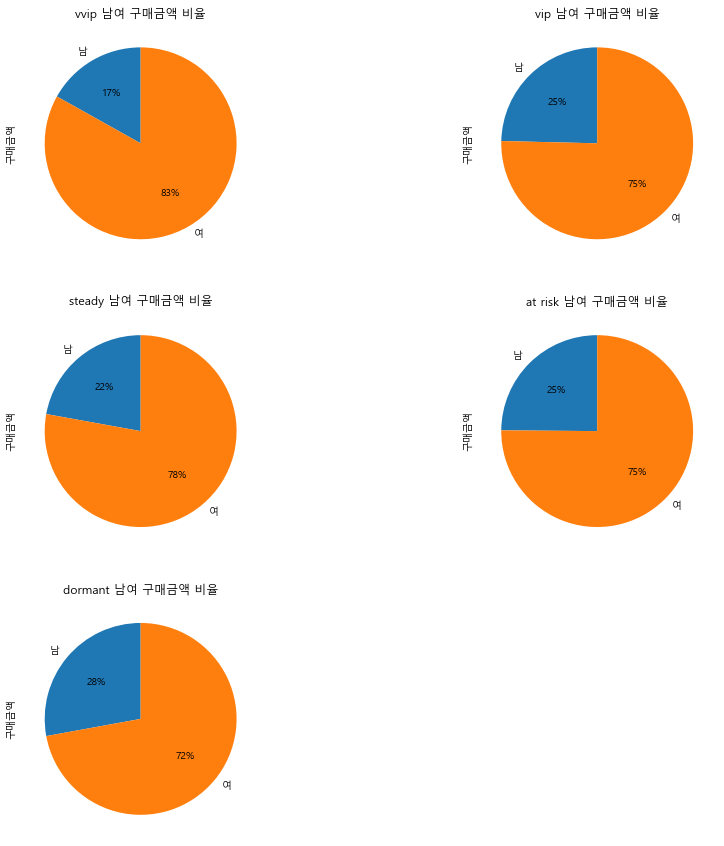

In [127]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
df.query('segment == "vvip"').groupby('성별')['구매금액'].sum().plot.pie(autopct='%.f%%', startangle=90)
plt.title('vvip 남여 구매금액 비율')

plt.subplot(3,2,2)
df.query('segment == "vip"').groupby('성별')['구매금액'].sum().plot.pie(autopct='%.f%%', startangle=90)
plt.title('vip 남여 구매금액 비율')

plt.subplot(3,2,3)
df.query('segment == "steady"').groupby('성별')['구매금액'].sum().plot.pie(autopct='%.f%%', startangle=90)
plt.title('steady 남여 구매금액 비율')

plt.subplot(3,2,4)
df.query('segment == "at risk"').groupby('성별')['구매금액'].sum().plot.pie(autopct='%.f%%', startangle=90)
plt.title('at risk 남여 구매금액 비율')

plt.subplot(3,2,5)
df.query('segment == "dormant"').groupby('성별')['구매금액'].sum().plot.pie(autopct='%.f%%', startangle=90)
plt.title('dormant 남여 구매금액 비율')
plt.show()

### ==>> 남/여의 성비의 차이와 구매금액 차이가 크기 때문에 각 성별에 적합한 마케팅전략을 구축하는 것이 적합.

* segment별 성별별 주요구매상품 (TOP 5)

In [128]:
df_f = df.query('성별 == "여"')
df_m = df.query('성별 == "남"')

* 여자

In [129]:
f = pd.pivot_table(df_f, index = '상품중분류명', columns = 'segment', values = '구매금액', 
                   aggfunc = np.sum, fill_value = 0).reset_index()

In [130]:
F_vvip_top5 = list(f.sort_values(by='vvip').상품중분류명.values[-5:])
F_vip_top5 = list(f.sort_values(by='vip').상품중분류명.values[-5:])
F_steady_top5 = list(f.sort_values(by='steady').상품중분류명.values[-5:])
F_at_risk_top5 = list(f.sort_values(by='at risk').상품중분류명.values[-5:])
F_dormant_top5 = list(f.sort_values(by='dormant').상품중분류명.values[-5:])

In [131]:
# 여자 segment별 매출 top5 항목 (vvip ~ dormant)
F_vvip_top5, F_vip_top5, F_steady_top5 , F_at_risk_top5, F_dormant_top5

(['생활가전', '명품', '여성용의류-SPA', 'TV/AV', '주방가전'],
 ['여성용의류-정장류', '생활가전', '여성용의류-SPA', 'TV/AV', '주방가전'],
 ['여성용의류-정장류', '여성용의류-SPA', '생활가전', 'TV/AV', '주방가전'],
 ['생활가전', '구두', '스포츠용품/의류', '주방가전', '여성용의류-SPA'],
 ['구두', '가공식품', '생활가전', '여성용의류-SPA', '주방가전'])

In [132]:
# top5의 품목이 segment별 전체 구매액 중 차지하는 비율
vvip=df_f.query('segment == "vvip" & 상품중분류명 == @F_vvip_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_f.query('segment == "vvip"').구매금액.sum()).sum()

vip=df_f.query('segment == "vip" & 상품중분류명 == @F_vip_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_f.query('segment == "vip"').구매금액.sum()).sum()

steady=df_f.query('segment == "steady" & 상품중분류명 == @F_steady_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_f.query('segment == "steady"').구매금액.sum()).sum()

at_risk=df_f.query('segment == "at risk" & 상품중분류명 == @F_at_risk_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_f.query('segment == "at risk"').구매금액.sum()).sum()

dormant=df_f.query('segment == "dormant" & 상품중분류명 == @F_dormant_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_f.query('segment == "dormant"').구매금액.sum()).sum()

print('vvip_top5 :', vvip.round(2))
print('vip_top5 :',vip.round(2))
print('steady_top5 :',steady.round(2))
print('at_risk_top5 :',at_risk.round(2))
print('dormant_top5 :',dormant.round(2))

vvip_top5 : 0.41
vip_top5 : 0.5
steady_top5 : 0.52
at_risk_top5 : 0.5
dormant_top5 : 0.52


* 남자

In [133]:
m = pd.pivot_table(df_m, index = '상품중분류명', columns = 'segment', values = '구매금액', 
                   aggfunc = np.sum, fill_value = 0).reset_index()

In [134]:
M_vvip_top5 = list(m.sort_values(by='vvip').상품중분류명.values[-5:])
M_vip_top5 = list(m.sort_values(by='vip').상품중분류명.values[-5:])
M_steady_top5 = list(m.sort_values(by='steady').상품중분류명.values[-5:])
M_at_risk_top5 = list(m.sort_values(by='at risk').상품중분류명.values[-5:])
M_dormant_top5 = list(m.sort_values(by='dormant').상품중분류명.values[-5:])

In [135]:
# 남자 segment별 매출 top5 항목 (vvip ~ dormant)
M_vvip_top5, M_vip_top5, M_steady_top5, M_at_risk_top5, M_dormant_top5

(['스포츠용품/의류', '명품', '주방가전', 'TV/AV', '여성용의류-SPA'],
 ['여성용의류-SPA', '명품', '생활가전', 'TV/AV', '주방가전'],
 ['PC/노트북/프린터/카메라', '남성용의류-캐주얼', '생활가전', 'TV/AV', '주방가전'],
 ['구두', '여성용의류-SPA', '주방가전', '생활가전', '스포츠용품/의류'],
 ['구두', '여성용의류-SPA', '스포츠용품/의류', '주방가전', '생활가전'])

In [136]:
# top5의 품목이 segment별 전체 구매액 중 차지하는 비율
vvip=df_m.query('segment == "vvip" & 상품중분류명 == @M_vvip_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_m.query('segment == "vvip"').구매금액.sum()).sum()

vip=df_m.query('segment == "vip" & 상품중분류명 == @M_vip_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_m.query('segment == "vip"').구매금액.sum()).sum()

steady=df_m.query('segment == "steady" & 상품중분류명 == @M_steady_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_m.query('segment == "steady"').구매금액.sum()).sum()

at_risk=df_m.query('segment == "at risk" & 상품중분류명 == @M_at_risk_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_m.query('segment == "at risk"').구매금액.sum()).sum()

dormant=df_m.query('segment == "dormant" & 상품중분류명 == @M_dormant_top5').groupby('상품중분류명')['구매금액'].agg(
    lambda x : x.sum()/df_m.query('segment == "dormant"').구매금액.sum()).sum()

print('vvip_top5 :', vvip.round(2))
print('vip_top5 :',vip.round(2))
print('steady_top5 :',steady.round(2))
print('at_risk_top5 :',at_risk.round(2))
print('dormant_top5 :',dormant.round(2))

vvip_top5 : 0.45
vip_top5 : 0.52
steady_top5 : 0.54
at_risk_top5 : 0.55
dormant_top5 : 0.57


* 전체적으로 상위5개의 품목의 총 구매금액 비율이 높으므로 신빙성이 있는 자료라 판단

# Marketing strategy

## 1. 여자

### (1) vvip

#### vvip는 더 발전할 등급이 없으므로 vvip들의 방문횟수를 증가 시키는 전략 구상

In [137]:
vvip_w = df_f.query('segment == "vvip" & 구매수량 > 0')

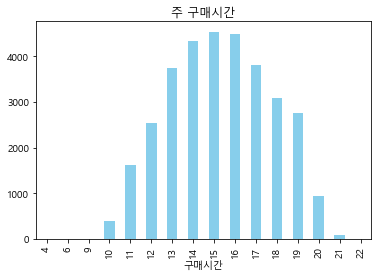

In [138]:
# 주 구매시간
vvip_w.groupby('구매시간')['num'].count().plot.bar(color='skyblue')
plt.title('주 구매시간')
plt.show()

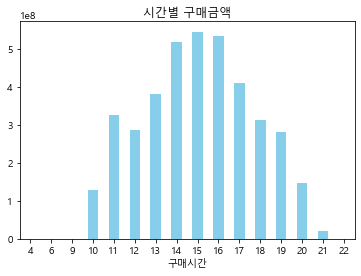

In [139]:
# 구매시간 별 구매금액
vvip_w.groupby('구매시간')['구매금액'].sum().plot.bar(rot = 0,color='skyblue')
plt.title('시간별 구매금액')
plt.show()

#### ==>> 주로 13~17시에 구매하는 사람이 많음을 알 수 잇음

#### ==>> 주로 13~17시에 구매금액이 큼

In [140]:
# 주 구매요일
vvip_w_d = pd.pivot_table(vvip_w, index = 'ID', columns = '구매요일', values = 'num',
                         aggfunc = 'count', fill_value = 0)[['월','화','수','목','금','토','일']]

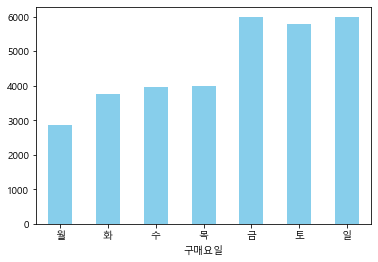

In [141]:
vvip_w_d.sum().plot.bar(xlabel = '구매요일', rot = 0,color='skyblue')
plt.show()

#### ==>> 주로 금/토/일에 비해 평일의  방문이 적다.

다른 세대보다 평일 여유시간이 많은 특성을 가진 실버세대 집단이다.

vvip와 실버세대란 특성을 반영하여 우선적으로 상대적으로 낮은 수치를 보이는 평일 방문횟수를 높히는 전략을 구축하는 것이 효율적이라 판단

- 예를 들어 평일에 백화점 내부 시설에서 실시하는 프리이엄 서비스 급 필라테스. 요가 와 같은 건강관련 힐링 프로그램 뮤지컬, 전시회 관람 같은 교양 프로그램을 무료 제공하여 평일 백화점 방문율을 높인다. (백화점 체류시간 또한 증가)
- 전용 라운지룸을 제공하여 백화점 체류시간을 증가시킨다.

-> 이는 궁극적으로 vvip 그들만의 공동체를 형성시켜 더 많은 매출 증가 효과를 기대 할 수 있다.

In [142]:
# 구매지역별 주요구매상품 (TOP5)
a = pd.pivot_table(vvip_w.query('성별 == "여"'), index = '상품중분류명', columns = '구매지역', values = '구매금액', aggfunc = np.sum, 
                   fill_value = 0)

In [143]:
local = list(df.query('segment=="vvip" & 성별 == "여"').구매지역.sort_values().unique())

In [144]:
qq=[list(a.sort_values(by=i, ascending = False).reset_index().상품중분류명.values[:5]) for i in local]

In [145]:
list_df = pd.DataFrame(local).rename(columns = {0 : '구매지역'})

In [146]:
c = pd.DataFrame(qq)

In [147]:
local_pd = pd.concat([list_df, c], axis = 1)
local_pd.columns = ['구매지역','1위','2위','3위','4위','5위']

In [148]:
# vvip 고객들이 가장 많이 구매한 지역 TOP5
state = pd.pivot_table(vvip_w, index = '구매지역',columns = 'segment', values = '구매금액', aggfunc =  np.sum, fill_value = 0)
vvip_state = list(state.sort_values(by = 'vvip',ascending = False).reset_index().구매지역[:5].values)

In [149]:
# TOP5 지역의 판매비율
vvip_w.query('구매지역 == @vvip_state').구매금액.sum() / vvip_w.구매금액.sum()

0.5169500391957577

In [150]:
d = local_pd.query('구매지역 == @vvip_state');d

,구매지역,1위,2위,3위,4위,5위
12,경기 안양시,여성용의류-SPA,화장품,여성용의류-정장류,남성용의류-캐주얼,골프용품/의류
46,서울 동대문구,생활가전,여성용의류-정장류,TV/AV,여성용의류-SPA,여성용의류-고급의류
51,서울 송파구,명품,여성용의류-SPA,주방가전,화장품,TV/AV
53,서울 영등포구,여성용의류-SPA,여성용의류-정장류,여성용의류-고급의류,주얼리,스포츠용품/의류
56,서울 중구,여성용의류-고급의류,명품,화장품,여성용의류-정장류,생활가전


In [151]:
r = pd.concat([d['1위'], d['2위'], d['3위'], d['4위'], d['5위']]).reset_index().rename(columns={0:'상품'})

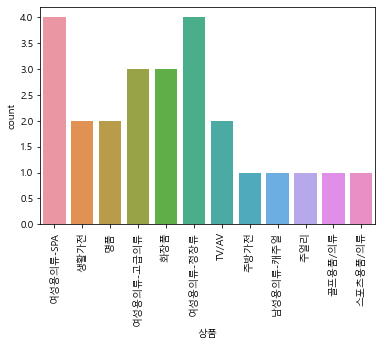

In [152]:
sns.countplot(data = r, x = '상품')
plt.xticks(rotation = 90)
plt.show()

#### ==>>여성용의류-SPA  ->  여성용의류/정장류 + 주방가전 + 화장품 -> 순으로 구매률이 높음

#### 추가전략

vvip들의 생일에 생일축하 선물을 배송 / 명품 잡지 수시 배송 과 같은 서비스를 제공. 

적립금 : 0.5% (전품목)

할인율 : 명품 / 가전 / 식품 품목을 제외한 전 품목 10% 할인 // 연간 최대 할인 한도 200만원

### (2) vip

#### vip는 구매일수, 구매금액을 늘리면 vvip가 될 수 있음

In [153]:
vip_w = df_f.query('segment == "vip"')

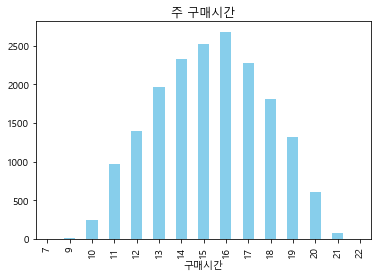

In [154]:
# 주 구매시간
vip_w.groupby('구매시간')['num'].count().plot.bar(color='skyblue')
plt.title('주 구매시간')
plt.show()

#### ==>> 주로 13~17시에 구매하는 사람이 많음을 알 수 있음

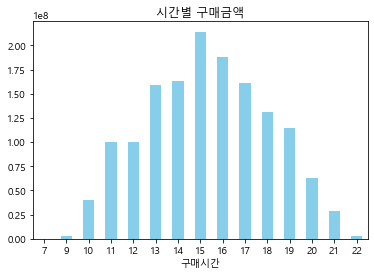

In [155]:
# 구매시간 별 구매금액
vip_w.groupby('구매시간')['구매금액'].sum().plot.bar(rot = 0,color='skyblue')
plt.title('시간별 구매금액')
plt.show()

#### ==>> 주로 13~17시에 구매금액이 큼

In [156]:
# 주 구매요일
vip_w_d = pd.pivot_table(vip_w, index = 'ID', columns = '구매요일', values = 'num',
                         aggfunc = 'count', fill_value = 0)[['월','화','수','목','금','토','일']]

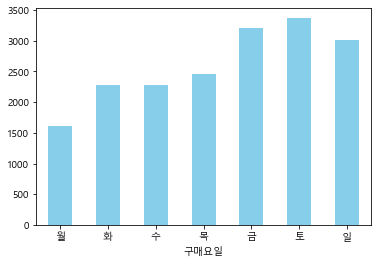

In [157]:
vip_w_d.sum().plot.bar(xlabel = '구매요일', rot = 0,color='skyblue')
plt.show()

#### ==>> 주로 금/토/일에 비해 평일에 고객 방문이 적다

vip 또한 실버세대의 특성을 반영하여 평일 방문율을 높이고 구매금액 또한 적절히 높이는 전략이 효율적이라 판단

In [158]:
# 구매지역별 주요구매상품 (TOP5)
a = pd.pivot_table(vip_w.query('성별 == "여"'), index = '상품중분류명', columns = '구매지역', values = '구매금액', aggfunc = np.sum, 
                   fill_value = 0)
local = list(df.query('segment=="vip" & 성별 == "여"').구매지역.sort_values().unique())
qq=[list(a.sort_values(by=i, ascending = False).reset_index().상품중분류명.values[:5]) for i in local]
list_df = pd.DataFrame(local).rename(columns = {0 : '구매지역'})
c = pd.DataFrame(qq)
local_pd = pd.concat([list_df, c], axis = 1)
local_pd.columns = ['구매지역','1위','2위','3위','4위','5위']

In [159]:
# vip 고객들이 가장 많이 구매한 지역 TOP5
state = pd.pivot_table(vip_w, index = '구매지역',columns = 'segment', values = '구매금액', aggfunc =  np.sum, fill_value = 0)
vip_state = list(state.sort_values(by = 'vip',ascending = False).reset_index().구매지역[:5].values)
vip_state

['경기 안양시', '서울 송파구', '서울 중구', '부산 해운대구', '서울 동대문구']

In [160]:
# TOP5 지역의 판매비율
vip_w.query('구매지역 == @vip_state').구매금액.sum() / vip_w.구매금액.sum()
d = local_pd.query('구매지역 == @vip_state');d

,구매지역,1위,2위,3위,4위,5위
10,경기 안양시,주방가전,TV/AV,생활가전,여성용의류-SPA,남성용의류-캐주얼
33,부산 해운대구,TV/AV,주방가전,생활가전,명품,남성용의류-캐주얼
44,서울 동대문구,여성용의류-정장류,주방가전,스포츠용품/의류,여성용의류-SPA,구두
50,서울 송파구,명품,주방가전,TV/AV,여성용의류-SPA,여성용의류-정장류
55,서울 중구,명품,여성용의류-SPA,여성용의류-고급의류,여성용의류-정장류,스포츠용품/의류


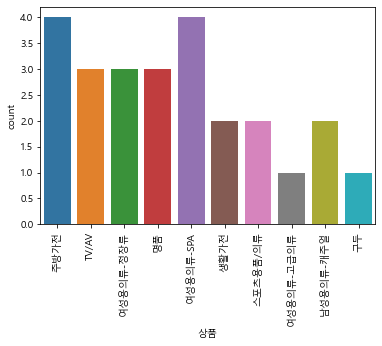

In [161]:
r = pd.concat([d['1위'], d['2위'], d['3위'], d['4위'], d['5위']]).reset_index().rename(columns={0:'상품'})
sns.countplot(data = r, x = '상품')
plt.xticks(rotation = 90)
plt.show()

#### 추가전략

적립금 : 0.4% (전품목)

할인율 : 명품 / 가전 / 식품 품목을 제외한 전 품목 7% 할인 // 연간 최대 할인 한도 100만원

- 생일인 고객들에게 생일 메세지와 선물을 챙겨준다.
- 명품 잡지들을 수시로 배송해준다.
- 전용 라운지룸을 제공하여 백화점 체류시간을 증가시킨다.

### (3) steady 

#### steady는 구매금액과 구매일수를 높여야 됨.

In [162]:
steady_w = df_f.query('segment == "steady"')

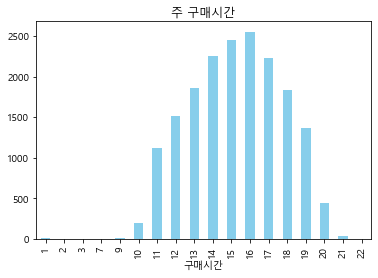

In [163]:
# 주 구매시간
steady_w.groupby('구매시간')['num'].count().plot.bar(color='skyblue')
plt.title('주 구매시간')
plt.show()

#### ==>> 주로 13~17시에 구매하는 사람이 많음을 알 수 잇음

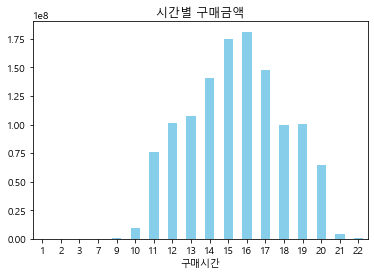

In [164]:
# 구매시간 별 구매금액
steady_w.groupby('구매시간')['구매금액'].sum().plot.bar(rot = 0,color='skyblue')
plt.title('시간별 구매금액')
plt.show()

#### ==>> 주로 13~17시에 구매금액이 큼

In [165]:
# 주 구매요일
steady_w_d = pd.pivot_table(steady_w, index = 'ID', columns = '구매요일', values = 'num',
                         aggfunc = 'count', fill_value = 0)[['월','화','수','목','금','토','일']]

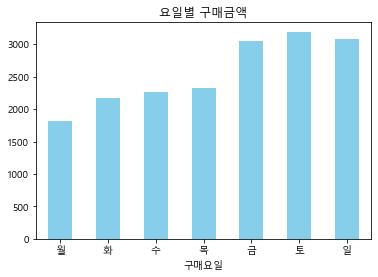

In [166]:
steady_w_d.sum().plot.bar(xlabel = '구매요일', rot = 0,color='skyblue')
plt.title('요일별 구매금액')
plt.show()

#### ==>> 주로 금/토/일에 고객이 방문이 많다

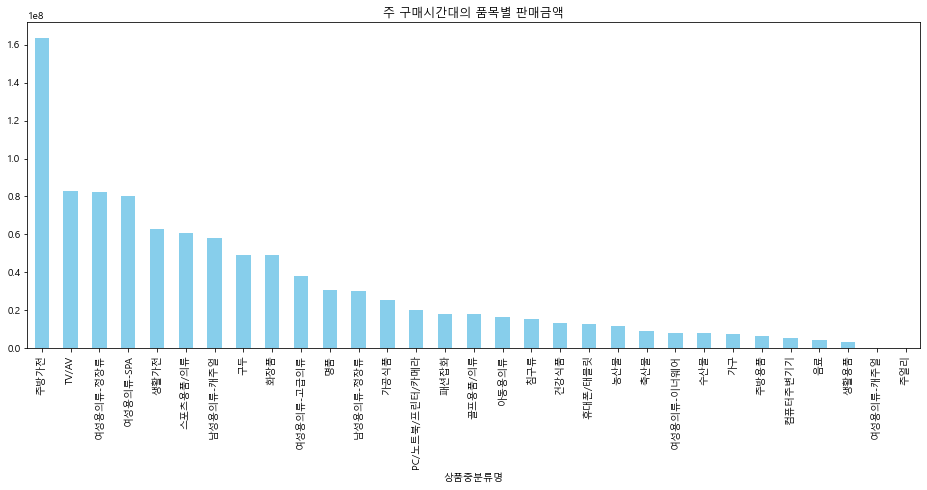

In [167]:
# 주 시간별 상품중분류
F_steady_mt = [13,14,15,16,17,18]
#list(steady_w.query('구매시간 == @F_steady_mt').groupby('상품중분류명')['구매금액'].sum().sort_values(ascending = False).index[:5])
steady_w.query('구매시간 == @F_steady_mt').query('구매수량 > 0').groupby('상품중분류명')['구매금액'].sum().sort_values(ascending = False).plot.bar(figsize = (16,6),color='skyblue')
plt.title('주 구매시간대의 품목별 판매금액')
plt.show()

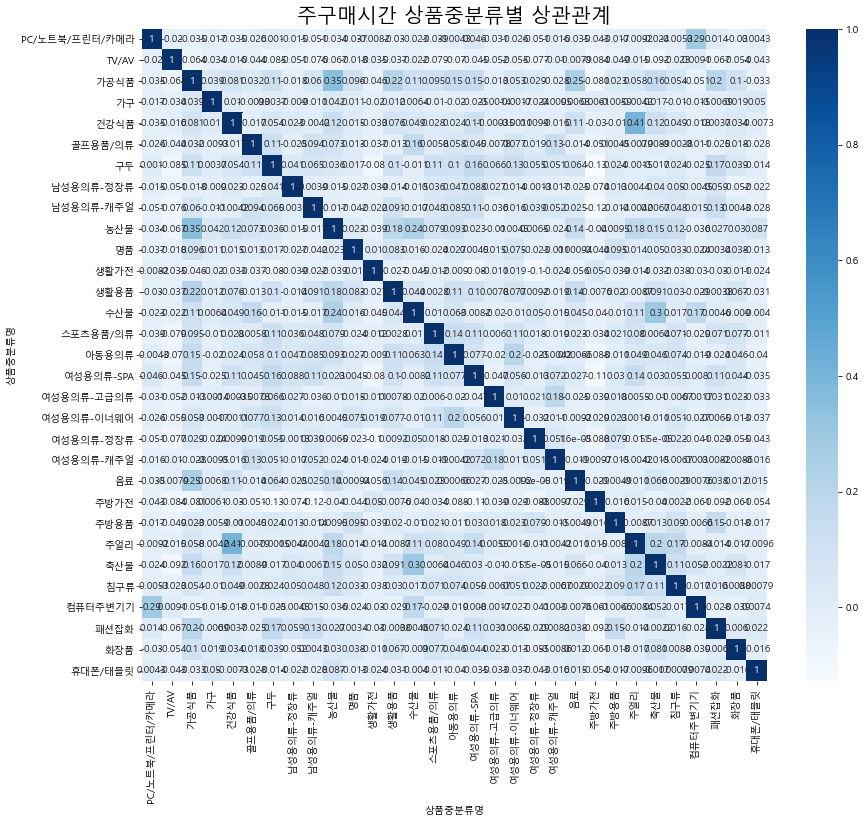

In [168]:
heat = pd.pivot_table(steady_w.query('구매시간 == @F_steady_mt'), index = 'ID', columns = '상품중분류명', values = '구매금액', aggfunc = np.sum,
              fill_value = 0)
plt.figure(figsize = (14,12))
sns.heatmap(heat.corr(), annot = True, cmap = 'Blues' )
plt.title('주구매시간 상품중분류별 상관관계',fontsize=20)
plt.show()

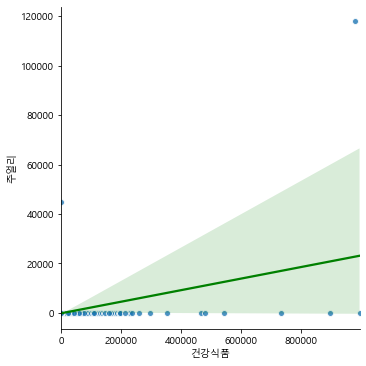

In [169]:
sns.lmplot(x='건강식품', y='주얼리', data=heat, 
           line_kws={'color':"green"}, scatter_kws={'edgecolor':"white"})
plt.show()

상품 별 눈에 띄는 상관관계가 존재하지 않아 특정 품목에 대한 할인 / 혜택과 같은 서비스 보단 전체 품목에 대한 구매를 독려하는 전략을 구축

분기 단위로 고객 내에서 등급 평가를 실시 -> 해당 등급별 혜택 차등 제공

Bronze : 적립금 : 0.1% + 5000원 할인쿠폰 3개 제공 (분기별)

Silver : 적립금 : 0.2% + 10.000원 할인쿠폰 2개 제공 (분기별)

Gold : 적립금 : 0.3% + 20000원 할인쿠폰 2개 제공 (분기별)

할인율은 할인쿠폰(분기단위 소멸 예정)으로 대체

Steady 그룹 등급 승급 기준 : 분기당 5번 이상 유효방문 (방문시 구매) + 구매금액 할인 제외 150000원 이상 구매  -  조건 불충족 시 강등

In [170]:
# 구매지역별 주요구매상품 (TOP5)
a = pd.pivot_table(steady_w.query('성별 == "여"'), index = '상품중분류명', columns = '구매지역', values = '구매금액', aggfunc = np.sum, 
                   fill_value = 0)
local = list(df.query('segment=="steady" & 성별 == "여"').구매지역.sort_values().unique())
qq=[list(a.sort_values(by=i, ascending = False).reset_index().상품중분류명.values[:5]) for i in local]
list_df = pd.DataFrame(local).rename(columns = {0 : '구매지역'})
c = pd.DataFrame(qq)
local_pd = pd.concat([list_df, c], axis = 1)
local_pd.columns = ['구매지역','1위','2위','3위','4위','5위']

In [171]:
# vvip 고객들이 가장 많이 구매한 지역 TOP5
state = pd.pivot_table(steady_w, index = '구매지역',columns = 'segment', values = '구매금액', aggfunc =  np.sum, fill_value = 0)
steady_state = list(state.sort_values(by = 'steady',ascending = False).reset_index().구매지역[:5].values)
steady_state

['서울 송파구', '경기 안양시', '부산 부산진구', '부산 해운대구', '서울 중구']

In [172]:
# TOP5 지역의 판매비율
steady_w.query('구매지역 == @steady_state').구매금액.sum() / vvip_w.구매금액.sum()
d = local_pd.query('구매지역 == @steady_state');d

,구매지역,1위,2위,3위,4위,5위
14,경기 안양시,주방가전,여성용의류-정장류,남성용의류-캐주얼,TV/AV,화장품
31,부산 부산진구,여성용의류-SPA,주방가전,구두,여성용의류-고급의류,화장품
39,부산 해운대구,주방가전,TV/AV,생활가전,스포츠용품/의류,여성용의류-SPA
57,서울 송파구,주방가전,여성용의류-SPA,생활가전,여성용의류-정장류,화장품
62,서울 중구,여성용의류-정장류,여성용의류-SPA,화장품,스포츠용품/의류,구두


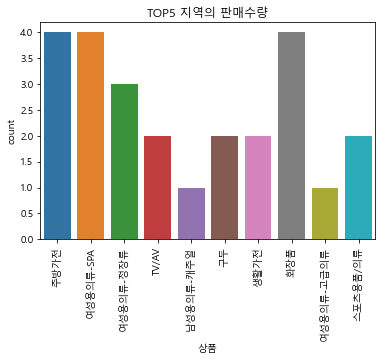

In [173]:
r = pd.concat([d['1위'], d['2위'], d['3위'], d['4위'], d['5위']]).reset_index().rename(columns={0:'상품'})
sns.countplot(data = r, x = '상품')
plt.xticks(rotation = 90)
plt.title('TOP5 지역의 판매수량')
plt.show()

### (4) at risk , dormant

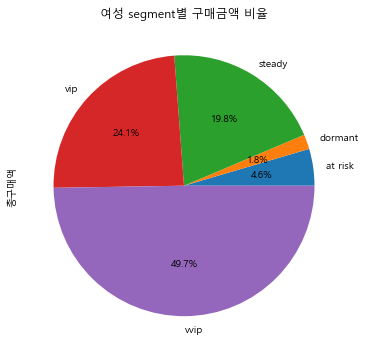

In [174]:
features.query('성별 == "여"').groupby('segment')['총구매액'].sum().plot.pie(figsize = (8,6), autopct = '%.1f%%')
plt.title('여성 segment별 구매금액 비율')
plt.show()

위의 pie 차트를 보면 알 수 있듯, at risk 와 dormant 집단 고객은 전체 구매금액에 큰 비율을 차지하지 않는다. 그러므로 그들만을 위한 특별한 전략을 구축할 필요성이 적다 판단되어, steady 그룹에게 구축된 'Steady 등급제'를 동일하게 적용한다.

단, steady 그룹보다 방문율이 적기 때문에 매장 방문 독려 문자, 홍보문자 등을 발송하여 방문율을 높이는 효과를 기대한다.

## 2. 남자.

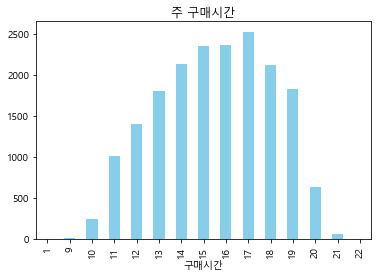

In [175]:
# 주 구매시간
df_m.groupby('구매시간')['num'].count().plot.bar(color='skyblue')
plt.title('주 구매시간')
plt.show()

#### ==>> 주로 14~17시에 구매하는 사람이 많음을 알 수 잇음

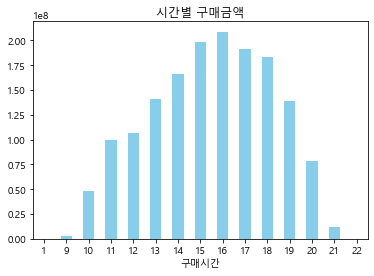

In [176]:
# 구매시간 별 구매금액
df_m.groupby('구매시간')['구매금액'].sum().plot.bar(rot = 0,color='skyblue')
plt.title('시간별 구매금액')
plt.show()

#### ==>> 주로 13~17시에 구매금액이 큼

In [177]:
# 주 구매요일
df_m_d = pd.pivot_table(df_m, index = 'ID', columns = '구매요일', values = 'num',
                         aggfunc = 'count', fill_value = 0)[['월','화','수','목','금','토','일']]

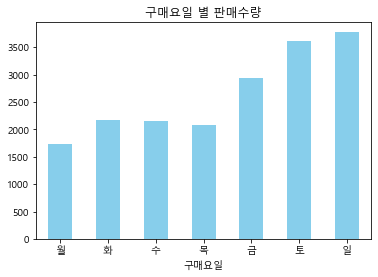

In [178]:
df_m_d.sum().plot.bar(xlabel = '구매요일', rot = 0,color='skyblue')
plt.title('구매요일 별 판매수량')
plt.show()

#### ==>> 주로 금/토/일에 고객이 방문이 많다

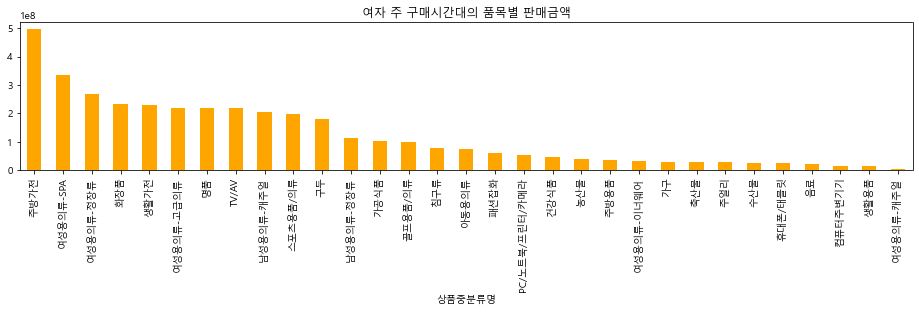

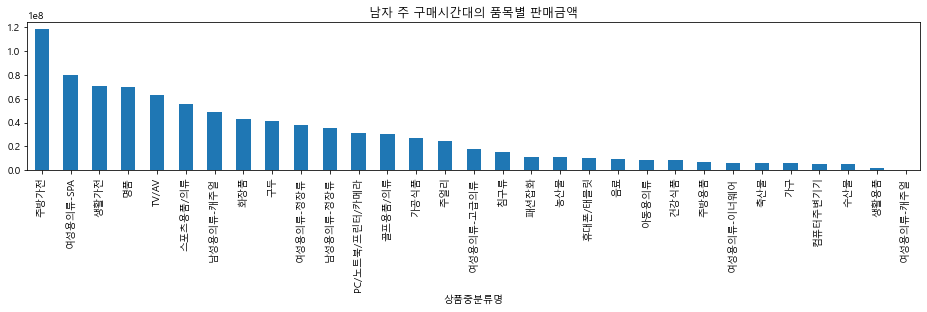

In [179]:
# 성별 별 주 시간별 상품중분류
F_vvip_mt = [13,14,15,16,17]
plt.subplot(2,1,1)
df_f.query('구매시간 == @F_vvip_mt').groupby('상품중분류명')['구매금액'].sum().sort_values(ascending = False).plot.bar(figsize = (16,6), color = 'orange')
plt.title('여자 주 구매시간대의 품목별 판매금액')
plt.show()


M_vvip_mt = [13,14,15,16,17]
plt.subplot(2,1,2)
df_m.query('구매시간 == @M_vvip_mt').groupby('상품중분류명')['구매금액'].sum().sort_values(ascending = False).plot.bar(figsize = (16,6))
plt.title('남자 주 구매시간대의 품목별 판매금액')
plt.show()

남녀의 주 구매시간대의 품목별 소비패턴이 거의 동일하다는 것을 알 수 있다. 이러한 패턴은 여성고객이 남성고객의 카드 (ex: 남편카드)를 사용하여 구매를 했다는 가능성도 배제할 수 없다고 판단하였다.

또한 남자의 고객수가 여자의 고객수보다 현저히 낮으며, 총 구매금액 또한 그러하다.

위와 같은 가능성을 염두하면 실질적인 남자 고객은 더 적다고 예측하여 우리는 여자에 해당되는 마케팅 전략을 남자고객에도 동일하게 적용하여도 된다고 판단하였다.

# 환불

In [180]:
abs(df.query('취소여부 == 1')['구매금액']).sum()

1576646000

In [181]:
df.query('취소여부 == 0')['구매금액'].sum()

df.query('취소여부 == 1')['구매금액'].sum()

print('환불금액비율 : ',round(abs(df.query('취소여부 == 1')['구매금액']
                .sum()/df.query('취소여부 == 0')['구매금액'].sum())*100, 2),'%')

print('환불비율 : ',round(abs(df.query('취소여부 == 1')['구매수량']
                .sum()/df.query('취소여부 == 0')['구매수량'].sum())*100, 2),'%')

환불금액비율 :  17.03 %
환불비율 :  9.62 %


In [182]:
b1,b2=(abs(df.query('취소여부 == 1')['구매금액'].sum())),df.query('취소여부 == 0')['구매금액'].sum()
b3,b4=(abs(df.query('취소여부 == 1')['구매수량'].sum())),df.query('취소여부 == 0')['구매수량'].sum()

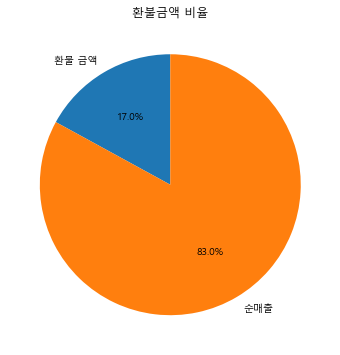

In [183]:
size=[b1,b2-b1]
label=['환불 금액','순매출']
plt.figure(figsize=(8,6))
plt.pie(size,labels=label,autopct='%1.1f%%',startangle = 90)
plt.title('환불금액 비율')
plt.show()

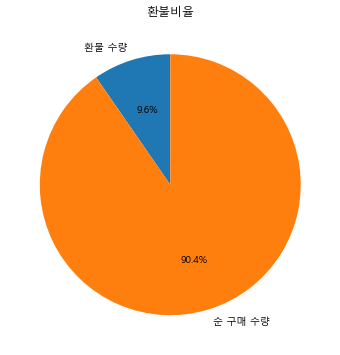

In [184]:
size=[b3,b4-b3]
label=['환불 수량','순 구매 수량']
plt.figure(figsize=(8,6))
plt.pie(size,labels=label,autopct='%1.1f%%',startangle = 90)
plt.title('환불비율')
plt.show()

- 환불 금액은 구매 금액의 17%를 차이하며 약 16억으로 많은 금액을 차지하고 있다.

새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.

In [185]:
features_r = pd.DataFrame({'ID' : df.ID.unique()})

**[1]** 총구매수량, 환불수량, 환불비율

In [186]:
a = df.query('취소여부 == 0').groupby('ID')['구매수량'].sum().reset_index().rename(columns = {'구매수량':'총구매수량'})
b = abs(df.query('취소여부 == 1').groupby('ID')['구매수량'].sum()).reset_index().rename(columns = {'구매수량':'환불수량'})

f = pd.merge(a,b, on ='ID', how = 'left')
f = f.fillna(0)
f['환불비율'] = f.환불수량/f.총구매수량
features_r = features_r.merge(f, how = 'left')
features_r

,ID,총구매수량,환불수량,환불비율
0,478207946,4,0.0,0.000000
1,479806984,5,0.0,0.000000
2,94790213,26,0.0,0.000000
3,656026338,3,0.0,0.000000
4,433076833,259,2.0,0.007722
...,...,...,...,...
3536,154314532,3,0.0,0.000000
3537,416998709,3,0.0,0.000000
3538,168692065,2,0.0,0.000000
3539,955481370,6,0.0,0.000000


**[2]** 총구매금액, 환불총액, 순매출, 환불경험

In [187]:
a = df.query('취소여부 == 0').groupby('ID')['구매금액'].sum().reset_index().rename(columns = {'구매금액':'총구매금액'})
b = df.query('취소여부 == 1').groupby('ID')['구매금액'].sum().reset_index().rename(columns = {'구매금액':'환불총액'})

f = pd.merge(a,b,how = 'left')
f = f.fillna(0)

features_r = features_r.merge(f,how = 'left')
features_r['순매출'] = features_r.총구매금액 + features_r.환불총액
features_r['환불경험'] = features_r.환불수량.apply(lambda x : 1 if x>0 else 0)
features_r

,ID,총구매수량,환불수량,환불비율,총구매금액,환불총액,순매출,환불경험
0,478207946,4,0.0,0.000000,320000,0.0,320000.0,0
1,479806984,5,0.0,0.000000,318000,0.0,318000.0,0
2,94790213,26,0.0,0.000000,216000,0.0,216000.0,0
3,656026338,3,0.0,0.000000,29000,0.0,29000.0,0
4,433076833,259,2.0,0.007722,1601000,-18000.0,1583000.0,1
...,...,...,...,...,...,...,...,...
3536,154314532,3,0.0,0.000000,846000,0.0,846000.0,0
3537,416998709,3,0.0,0.000000,41000,0.0,41000.0,0
3538,168692065,2,0.0,0.000000,10000,0.0,10000.0,0
3539,955481370,6,0.0,0.000000,1219000,0.0,1219000.0,0


# 환불이 늘어나면 백화점에서는 손해가 아닐까?

### 환불경험이 있는 고객들의 순매출 합과 고객 수

In [188]:
features_r.query('환불경험 == 1').순매출.sum() , len(features_r.query('환불경험 == 1'))

(5429532000.0, 1553)

### 환불경험이 없는 고객들의 순매출 합과 고객 수

In [189]:
features_r.query('환불경험 == 0').순매출.sum(), len(features_r.query('환불경험 == 0'))

(2250595000.0, 1988)

### 환불경험이 없는 고객과 환불경험이 있는 고객의 순매출 평균

In [190]:
print('환불경험 X :' , features_r.query('환불경험 == 0').순매출.mean() ,
      "        ",'환불경험 O :',features_r.query('환불경험 == 1').순매출.mean())

환불경험 X : 1132090.0402414487          환불경험 O : 3496157.1152607854


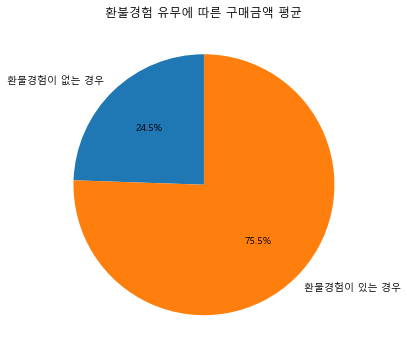

In [191]:
size=[1132090.0402414487,3496157.1152607854]
label=['환불경험이 없는 경우','환불경험이 있는 경우']
plt.figure(figsize=(8,6))
plt.pie(size,labels=label,autopct='%1.1f%%',startangle = 90)
plt.title('환불경험 유무에 따른 구매금액 평균')
plt.show()

환불경험이 없는 고객의 순매출의 평균보다 환불경험이 있는 고객들의 순매출의 평균이 약 3배 이상 크다는 것을 알 수 있다

- 환불을 통해 고객들의 재방문 유도 -> 매출 증가로 예상
- 잘 갖춰준 환불 시스템을 통해 고객들과의 신뢰감 형성 기대 -> 매출 증가로 예상

## 환불을 위한 재방문이 구매로 이어지는가 ?

In [192]:
from tqdm.notebook import tqdm
s=0
yes=0
no=0
for a in tqdm(features_r['ID']):
    df1=df.query('ID==@a')
    da=list(set(df1.query('취소여부==1')['구매일자']))
    dm=list(df1.query('구매일자 in @da & 취소여부==1').groupby('구매일자')['구매시간'].max())
    for i,value in enumerate(da):
        k=value
        g=dm[i]
        l=df1.query('구매일자 == @k & 구매시간>=@g &취소여부==0')
        if len(l)>=1:
            yes+=1
            s+=(l['구매금액'].sum())
        else: no+=1
y=df.query('취소여부==1')['구매금액'].sum()
print(f'환불하러 와서 제품을 추가적으로 구매한 건수 : {yes} 환불만 하고 돌아간 건수 : {no}')
print(f'환불한 뒤 총 구매 금액 : {s} 모든 환불 총 금액 : {y}')


환불하러 와서 제품을 추가적으로 구매한 건수 : 3084 환불만 하고 돌아간 건수 : 2063
환불한 뒤 총 구매 금액 : 1187980000 모든 환불 총 금액 : -1576646000


In [193]:
round(yes/(no+yes),2), -s/y

(0.6, 0.7534855636585511)

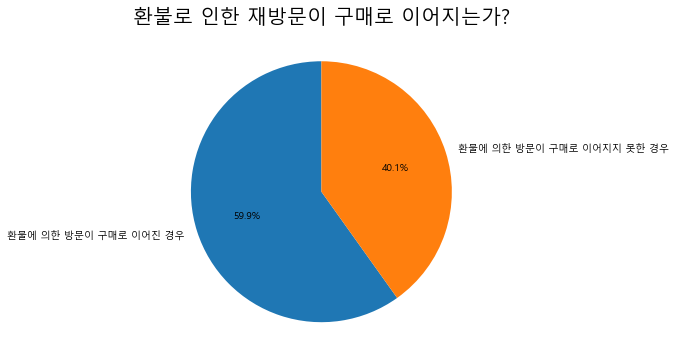

In [194]:
size=[3081,2066]
label=['환불에 의한 방문이 구매로 이어진 경우','환불에 의한 방문이 구매로 이어지지 못한 경우']
plt.figure(figsize=(8,6))
plt.pie(size,labels=label,autopct='%1.1f%%',
       startangle = 90)
plt.title('환불로 인한 재방문이 구매로 이어지는가?',fontsize=20)
plt.show()

- 환불을 통한 재방문으로 구매를 하는 확률은 약 60퍼로 환불을 통해 구매를 유도할 수 있다는 것을 알 수 있다.

- 환불을 통한 재방문으로 구매한 금액은 약 12 억으로 환불금액(약 15.8 억)보다는 2.8억이 적지만 불가피한 환불이 있다고 생각하면             적다고 생각할 수 없다. 

## 그렇다면 환불을 늘리는 것이 좋은가?

In [195]:
features_r.query('환불경험 == 1')['환불비율'].quantile([.25,.5,.75])

0.25    0.052632
0.50    0.107143
0.75    0.195122
Name: 환불비율, dtype: float64

In [196]:
x = features_r.query('환불경험 == 0')
q1 = features_r.query('환불경험 == 1').query('환불비율<0.052632')
q2 = features_r.query('환불경험 == 1').query('0.052632<=환불비율<0.107143')
q3 = features_r.query('환불경험 == 1').query('0.107143<=환불비율<0.195122')
q4 = features_r.query('환불경험 == 1').query('0.195122<=환불비율')

q1['q'] = 'q1'
q2['q'] = 'q2'
q3['q'] = 'q3'
q4['q'] = 'q4'

f = pd.concat([q1,q2,q3,q4,x])
f = f.fillna('X')
f

a = features[['ID','segment']]
a

q_seg = pd.merge(f,a,on = 'ID', how = 'left')
q_seg

,ID,총구매수량,환불수량,환불비율,총구매금액,환불총액,순매출,환불경험,q,segment
0,433076833,259,2.0,0.007722,1601000,-18000.0,1583000.0,1,q1,vip
1,306915014,370,3.0,0.008108,14972000,-189000.0,14783000.0,1,q1,vvip
2,887556868,21,1.0,0.047619,2664000,-152000.0,2512000.0,1,q1,steady
3,510195294,168,3.0,0.017857,6818000,-1651000.0,5167000.0,1,q1,vvip
4,485721733,76,1.0,0.013158,976000,-9000.0,967000.0,1,q1,at risk
...,...,...,...,...,...,...,...,...,...,...
3536,154314532,3,0.0,0.000000,846000,0.0,846000.0,0,X,vip
3537,416998709,3,0.0,0.000000,41000,0.0,41000.0,0,X,dormant
3538,168692065,2,0.0,0.000000,10000,0.0,10000.0,0,X,dormant
3539,955481370,6,0.0,0.000000,1219000,0.0,1219000.0,0,X,vvip


In [197]:
seg = pd.pivot_table(q_seg, index = 'segment', columns = 'q', values = 'ID', 
                       aggfunc = 'nunique', fill_value = 0, margins = True)

각 분위수별 segment 수

In [198]:
seg

q,X,q1,q2,q3,q4,All
segment,,,,,,
at risk,364,43,60,69,56,592
dormant,735,4,26,32,80,877
steady,514,96,95,96,105,906
vip,242,119,97,86,72,616
vvip,133,138,99,106,74,550
All,1988,400,377,389,387,3541


각 분위수별 segment 비율

<ipython-input-199-a007715f8fda>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('환불 비율에 따른 Segment 비율', FontSize = 15)


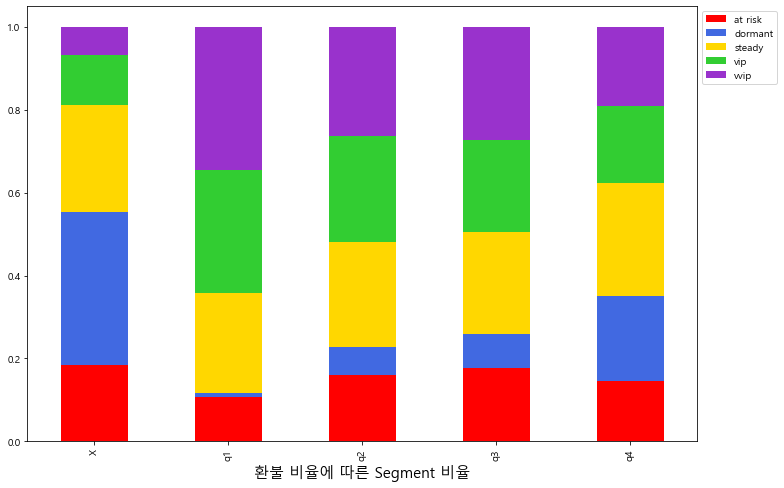

In [199]:
seg_per = seg.div(seg.loc['All'], axis = 1).iloc[:-1,:-1]
seg_per
colors=['red','royalblue','gold','limegreen','darkorchid']
seg_per.T.plot.bar(stacked = True, figsize = (12,8),color=colors)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('환불 비율에 따른 Segment 비율', FontSize = 15)
plt.show()

이 그래프를 보면 X(환불을 한적이 없는 그룹)는 vvip,vip비율이 상대적으로 q1-q4(환불을 한적이 있는 그룹)에
비해 적다. 또한 X는 dormant,at risk 비율이 q1-q4에 비해 크게 나타난다.
이는 환불을 무조건 지양할 필요는 없고 어느정도 권장하면 매출에 영향을 미칠 수 있다는것을 나타낸다.
또한 q1 -> q4로 이동하면서 보면 vip의 비율은 점점 줄어드는 모양이고 vvip는 약간 차이가 있지만 비슷한
모양을 보인다. 또 at risk, dormant의 비율은 점점 증가하는 모습을 볼 수있어 환불을 해본적 있는 인원들의
환불 비율을 어느정도 줄이는것도 중요하다.

환불비율 별 평균구매금액의 변화

In [200]:
def divid(x):
    for a,i in enumerate(range(0,100,5)):
        if i<100*x<=i+5: return f'{i}~{i+5}'
    if x==0: return 0
q_seg['환불비율분류']=q_seg['환불비율'].apply(divid)
a3=q_seg.groupby("환불비율분류")['순매출'].mean().reset_index()
a3['순서']=[1,2,4,5,6,7,8,9,10,11,12,13,3,14,15,16,17,18,19]
a3=a3.sort_values(by='순서')

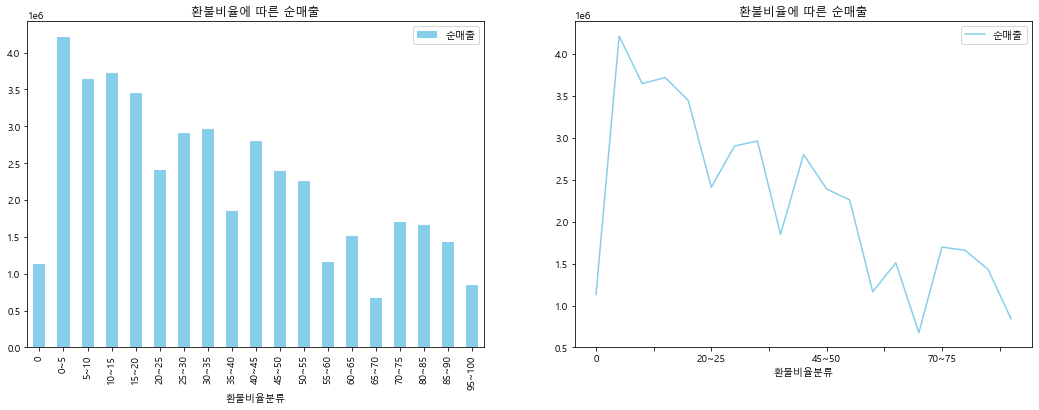

In [201]:
fig, ax = plt.subplots(1,2 ,figsize=(18,6))
plt.title('환불비율에 따른 순매출')
a3.plot.bar(x='환불비율분류',y='순매출',color='skyblue',ax=ax[0])
ax[0].set_title('환불비율에 따른 순매출')
a3.plot(x='환불비율분류',y='순매출',color='skyblue',ax=ax[1])
ax[1].set_title('환불비율에 따른 순매출')
plt.show()

- 환불율이 0보다 크면 평균구매액이 커지지만 환불율이 커질수록 평균구매액은 작아진다.
- 환불율이 60퍼에 가까워졌을 때 환불을 안한 고객의 평균구매액과 비슷해진다.
- 하지만 환불율 60퍼인 고객과 0퍼인 고객이 평균구매액이 같더라도 환불에 해당하는 서비스를 제공하기 위한 여러 자원이 들어가기 때문에
- 평균구매액이 같다면 환불율이 적은 고객이 더 좋다.

## 결론 : 환불을 하게끔 유도하는 것이 좋지만, 과도한 환불은 기피해야한다.

- 체계적인 환불 시스템을 구축하고, 환불 시스템에 대하여 고객들에게 설명해주어 고객들과 신뢰도를 구축한다.
-  -> 환불을 어느정도 유도하여 재방문으로 인한 구매를 유도.

- 환불량이 너무 많은 고객들에게 패널티 제도를 부여한다.
- 환불수수료(50000원 이하) = 1000원 / (50000원 이상) = 금액* 2% (신선도에 영향이 있는 식품류 /명품/가전 환불X)
- 일단 환불을 한번도 한 적 없는 환불비율 =0%인 그룹은 첫 환불 시 무료환불 + 할인쿠폰을 주는 식으로 환불 독려
- 0-20% 인원들은 환불수수료를 유지
- 20-40% 인원들은 환불수수료(50000원 이상) = 금액*3%
- 40-60% 인원들은 환불수수료(50000원 이하) = 1500원 / 환불수수료(50000원 이상) = 금액*5%
- 60%- 단순 변심으로 인한 환불 불가로 환불비율이 낮은 인원은 현 상태 유지를 시키면서 환불 비율이 높은 인원들에게는 패널티를   주어 환불 비율을 낮출 수 있게 독려한다.